# Assignment 4

### Teaching Assistants:
- Thomas de Bel: thomas.debel@radboudumc.nl
- Ecem Lago: ecem.lago@radboudumc.nl

Please submit your notebook via grand-challenge.org (https://ismi-cifar.grand-challenge.org/introduction/).
Submit a notebook **WITH ALL CELLS EXECUTED!!!**

* Groups: You should work in pairs or alone
* Deadline for this assignment: 
 * Monday, February 25th until 23:59h
 * 5 points (maximum grade = 100 points) penalization per day after deadline
* Submit your **fully executed** notebook to the grand-challenge.org platform
* The file name of the notebook you submit must be NameSurname1_NameSurname2_NameSurname3.ipynb
* The grades will be available before March 4th (tentative)


# Image classification with convolutional neural networks

<img src="./figures/cifar_10.jpg" alt="CIFAR10" align="right" width="450">

In this assignment, we are going to build, train and validate **convolutional neural networks** (ConvNets).
For this purpose, we will use data from the publicly available CIFAR10 dataset.
CIFAR10 is a dataset commonly used in the community of computer vision and machine learning to benchmark new algorithms and network architectures.

CIFAR10 is a dataset that contains (small) RGB images of 32x32 px of ten different classes:
    * airplane										
    * automobile										
    * bird										
    * cat										
    * deer										
    * dog										
    * frog										
    * horse										
    * ship										
    * truck
More details can be found at this link: https://www.cs.toronto.edu/~kriz/cifar.html

We recently searched for the state-of-the-art result on this dataset, and apparently an error of **2.31** on the test set (accuracy = 97.69) has been recently reached. The approach is described in this paper: https://openreview.net/pdf?id=S1NHaMW0b

In this assignment, you will probably reach an accuracy between 60% and 70%, which is perfectly fine!

# Data
We will train our ConvNet with images from CIFAR10, a dataset of 60,000 colour images of 32x32 pixels in 10 classes. The downloaded training samples come split into 5 batches of 10,000 samples each, which is useful to do cross-validation for example. In this assignment, you will have to decide how to best split the dataset into training and validation sets. A separate test set is provided in CIFAR10, which is the same set used by other researchers to benchmark their methods.

# Tasks
We define 10 tasks in this assignment.
Although 10 tasks sound like a lot of work, you will see that (1) they are highly repetitive (meaning, you will do a lot of copy-paste across cells in the notebook), (2) you can reuse most of the things you did last week.
Like we mentioned in the lecture this week, given the experience you have gained by defining datasets and training neural networks, training convolutional neural networks is just a natural step towards using a different architectures (and some additional tricks and tools).

---

The task that we propose are the following:

### Task 1. Split data and build convolutional networks (30 points)
In this task, you will first define your training and validation set, then you will build the architecture of convolutional networks.

### Task 2. Train convolutional networks (20 points)
In this task, you will train your first model using CIFAR10, apply the trained model to the test set, and submit the results to grand-challenge. In order to define training functions and parameteres, you can reuse a lot of code developed last week.

### Task 3. Add dropout layer(s) (5 points)
In this task, you will modify the architecture of your network by adding dropout, which is implemented in Keras in the form of a layer. After that, you will repeat the training procedure and compare the results with the ones of the *plain* network.

### Task 4. Add batch normalization (5 points)
In this task, you will do something similar to task 3, but now adding batch normalization.
You will repeat the experiment and compare the performance with previous architectures.

### Task 5. Try different initialization strategies (5 points)
We have seen that at least a couple of initilization strategies are known in the literature for (convolutional) neural networks.
Several strategies are implemented in the Keras library.
Try some of them and report the results.

### Task 6. Try different nonlinearities (5 points)
The same for nonlinearities, we have seen that ```ReLU``` is some kind of default choice for ConvNets, but other strategies exists. Do experiments, report the results and compare with previous approaches.

### Task 7. Add L2 regularization (5 points)
Modify the loss function to use L2 regularization.
Again, run experiments and report results.

### Task 8. Add data augmentation (15 points + 10 bonus points)
Think of possible ways you can augment the (training) data.
You can build a new (bigger) training set, or implement some kind of data augmentation *on-the-fly*, where some patches in the mini-batch are randomly selected and augmented with a (random) operation. Think of transformations that make sense in the context of classification of natural images.

### Task 9. Try different architecture (10 points)
You can try to improve the performance by modifying the architecture, using more layers, or wider layers (same number of layers but more filters, which means more parameters). Use all the tools you have investigated so far, the optimal combination of the options you have tried in previous tasks. The goal is to get high accuracy on the validation (and therefore on the test) set!

### Task 10 (optional). Monitor the training procedure (max 10 points)
Finally, an optional task is to implement some tools to monitor the training procedure.
Examples are the analysis of statistics of activations, or visualizing the filters learned.
If done during training, visualizing filter will also nicely show how the network refines random parameters to come up with meaningful filters (especially in the first layer).

---


As done in previous assignments, in this notebook we provide some parts of code implemented.
Some other parts are not implemented, but we define the variables that will be used in functions, to help you in the development of the assignment.
Things that have been declared but not implemented are assigned a **None** value.
That is the part that you have to implement.
This means that every time you see **None**, it means that something is missing and you have to implement it.

## Reporting your results

When you are done with the assignments you will have to hand in this notebook. Make sure that for each assignment you output a summary of the network architecture and a plot of the loss/accuracy curve during training. This output will be used to grade your assignment.

## Let's get started

In [16]:
# import libraries
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 12)
from tqdm import tnrange, tqdm_notebook
from IPython import display
import time
import tensorflow as tf
import keras
from keras import layers, models, activations, optimizers
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K

K.tensorflow_backend._get_available_gpus()



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6520577258548873628
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9720832393877353777
physical_device_desc: "device: XLA_CPU device"
]


[]

## Confusion matrix
Import the confusion matrix code from last weeks assignment. 
We use this to conduct some eyeballing over the results of the validation set.
If there happen to be any classes that are poorly classified, then we can see it from the confusion matrix.

In [17]:
# Intermediate: 
# Take the confusion matrix from the previous assignment for model analysis.

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(conf_mat, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix
    """
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, conf_mat[i, j], horizontalalignment="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Get to know your data: Load data and define datasets

CIFAR10 contains 5 batches that can be used for training/validation, and one batch that consists of the test set.
In order to train your network, you will have to define a training set and a validation set. Do not use the test set as training data, and do not use any knowledge on the labels of the test set (being a publicly available dataset, we cannot avoid exposing the labels of the test set).


Think of the best way to split data into training and validation set. Note that the format that layers in convolutional networks like (at least in the Keras/Tensorflow libraries that we are using), is as follows:

    (n_samples, rows, cols, n_channels)

This means that each training (but also validation and test) sample needs to have four dimensions. This kind of structure (multi-dimensional array), is called a **tensor**. In practice, this format is also convenient because the first index of the tensor refers to the sample itself, so we can use:

    tensor[i]
    
to extract the i-th example.

During training, several samples will be used to update the parameters of a network. In the case of CIFAR10, if we use M samples per mini-batch, the shape of the mini-batch data is:

    (M, 32, 32, 3)

Make sure data is organized in this way, for the training, validation and test datasets.

### Download CIFAR10 data
The following cell will download the 5 batches of the CIFAR10 training dataset as well as the test set to your disk and load it in memory.

In [18]:
from keras.utils.data_utils import get_file
origin_url = 'https://surfdrive.surf.nl/files/index.php/s/{key}/download'

# Dictionary mapping file names to download keys
files = {
    'cifar10-batch-1': '4Nee36XgbYjp3N6',
    'cifar10-batch-2': 'LVx85dLceKI5toF', 
    'cifar10-batch-3': '4FoFmeKyXa5sYr0',
    'cifar10-batch-4': 'a4o2RatC0Fa3Exb',
    'cifar10-batch-5': 'eqBJRWdkRGk025k',
    'cifar10-test': 'nEf9Z4eg7iGmWGU'
}

# Download files to local drive (only downloads the files once)
local_files = [{'name': name, 'file': get_file(name, origin=origin_url.format(key=key))} for name, key in files.items()]

# Load all batches in memory
batches = {lf['name']: pickle.load(open(lf['file'], 'rb'), encoding='latin1') for lf in local_files}

# Convert data to floats and reshape to correct format
# This is specific for CIFAR10
for batch in batches.values():
    # Images were originally used as (CxWxH), convert to (WxHxC)
    batch['data'] = (batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.).astype("float32")

data_size_in=(32, 32, 3)
n_classes=10

The CIFAR dataset is now loaded in memory in the form of a Python dictionary. To get to know your data, check what are the keys of such a dictionary:

In [19]:
print(batches.keys())

dict_keys(['cifar10-batch-1', 'cifar10-batch-2', 'cifar10-batch-5', 'cifar10-batch-3', 'cifar10-test', 'cifar10-batch-4'])


Before you define your datasets, it is useful to check the distribution of labels across batches of CIFAR10, in case some batches have skewed distributions of labels.
In order to do that, you can use visualize the histogram of labels using the function ```hist()``` of the matplotlib library:

    plt.hist()

Text(0.5,1,'batch_5')

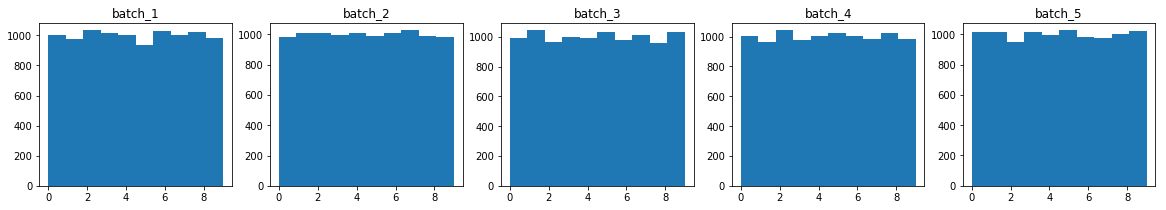

In [20]:
fig = plt.figure(figsize=(20, 3))
plt.subplot(1,5,1); plt.hist(batches['cifar10-batch-1']['labels']); plt.title('batch_1')
plt.subplot(1,5,2); plt.hist(batches['cifar10-batch-2']['labels']); plt.title('batch_2')
plt.subplot(1,5,3); plt.hist(batches['cifar10-batch-3']['labels']); plt.title('batch_3')
plt.subplot(1,5,4); plt.hist(batches['cifar10-batch-4']['labels']); plt.title('batch_4')
plt.subplot(1,5,5); plt.hist(batches['cifar10-batch-5']['labels']); plt.title('batch_5')

#### Question
Do you think that you have to organize batches in a specific way in order to make a training and a validation set, and would this affect the performance of your network significantly?

The batches are each uniformly distibuted, so we do not have to organize the batches in a specific way to have each class well represented in each batch. However, using 4 random batches to make a training set and the remaining batch as validation set would affect the performance significantly, since taking 20% off the training set as validation set reduces the training set too much, increasing the probability of underfitting the network. So we merge the batches and randomly extract 10% of the batches as validation set.

Implement now a function ```load_data``` that builds and returns the training and validation datasets. You will be using this function in your experiments later.

In [21]:
def load_data(n_samples_total=None):

    # merge all the five batches into one big set
    labels = []
    data = []

    for batch_name in batches:
        batch = batches[batch_name]
        labels.append(batch['labels'])
        data.append(batch['data'])

    labels = np.concatenate(labels)
    data = np.concatenate(data)

    # take a random subsample for faster computation
    if n_samples_total is not None:
        np.random.seed(42)
        idx = np.random.choice(np.arange(len(data)), n_samples_total, replace=False)
        data = data[idx]
        labels = labels[idx]
    # standard train-validation split, 10 % validation
    train_x, val_x, train_y, val_y = train_test_split(data,labels, test_size=0.1,random_state=42, stratify = labels)

    # make test set
    test_x = batches['cifar10-test']['data']
    
    #TODO: DELETE THIS BEFORE HANDING IN
    test_y = batches['cifar10-test']['labels']
    
    # load labels CIFAR10
    label_to_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

    print ("-----------------------------------------------------")
    print (label_to_names)
    print ("-----------------------------------------------------")
    print ("> shape training set tensor: {}".format(train_x.shape))
    print ("> length training labels: {}".format(len(train_y)))
    print ("-----------------------------------------------------")
    print ("> shape validation set tensor: {}".format(val_x.shape))
    print ("> length training labels: {}".format(len(val_y)))
    print ("-----------------------------------------------------")
    print ("> shape test set tensor: {}".format(test_x.shape))
    
    # TODO: DELETE TEST_Y BEFORE HANDING IN
    return train_x, train_y, val_x, val_y, test_x, test_y

load_data()

-----------------------------------------------------
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
-----------------------------------------------------
> shape training set tensor: (54000, 32, 32, 3)
> length training labels: 54000
-----------------------------------------------------
> shape validation set tensor: (6000, 32, 32, 3)
> length training labels: 6000
-----------------------------------------------------
> shape test set tensor: (10000, 32, 32, 3)


(array([[[[0.52156866, 0.65882355, 0.70980394],
          [0.5254902 , 0.6627451 , 0.69411767],
          [0.5254902 , 0.6627451 , 0.7058824 ],
          ...,
          [0.5372549 , 0.654902  , 0.7176471 ],
          [0.53333336, 0.6509804 , 0.72156864],
          [0.5411765 , 0.65882355, 0.7411765 ]],
 
         [[0.5372549 , 0.60784316, 0.6117647 ],
          [0.5411765 , 0.57254905, 0.5803922 ],
          [0.6039216 , 0.65882355, 0.6666667 ],
          ...,
          [0.62352943, 0.6862745 , 0.7137255 ],
          [0.62352943, 0.6784314 , 0.7176471 ],
          [0.627451  , 0.6862745 , 0.73333335]],
 
         [[0.4509804 , 0.34117648, 0.34117648],
          [0.44313726, 0.27450982, 0.29411766],
          [0.53333336, 0.40784314, 0.4117647 ],
          ...,
          [0.6509804 , 0.64705884, 0.6313726 ],
          [0.65882355, 0.6392157 , 0.63529414],
          [0.65882355, 0.6431373 , 0.6509804 ]],
 
         ...,
 
         [[0.23921569, 0.36078432, 0.23921569],
          [0.28627

# Task 1: build a simple convolutional network

In this task you create the definition of your convolutional network. You can use parts of the code of  last week as an example. If you want you can check out the **functional API** of Keras; this API enables you to make more advanced models and is more flexible to use. A guide can be found here: https://keras.io/getting-started/functional-api-guide/

Example of sequential API:
```python
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(32, input_dim=784), activation='relu)
model.add(layers.Dense(32, activation='relu)
model.add(layers.Dense(10, activation='softmax'))

model.compile(...)
```

Example of same model using the functional API (**recommended**):

```python
from keras import models, layers

inputs = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(...)
```

The functional API can look a bit more complex at start in comparision to the sequential API. However, it gives you access to each individual layer and lets you more easily build up your network. The only difference between the two APIs is the way you build up your network, all other parts (training, applying a network, etc.) are the same.

For the assignments it does not matter which API you choose, **you are free to choose the sequential or functional API**. For the final assignment of the course it can be usefull to get some experience with the functional API.

### Network
Define your network builder function. 
We build a convolutional network that contains:

1. input layer
2. convolutional layer
3. max pooling layer
4. convolutional layer
5. max pooling layer
6. fully-connected layer(s)
7. soft-max layer

### Hint

1. Select the number of convolutional and max pooling layers and choose the filter size so that the input image is shrunk to 5x5 before the fully connected layers.
2. Use at least one fully connected layer between the last convolutional layer and the output layer (which is the fully connected layer with softmax nonlinearity).
3. You can reuse the code you used last week to build a fully-connected network, just remember that this time you have to use convolutional layers!

In [22]:
# Define your network builder function. You can assume the (32, 32, 3) input size.
#
def build_neural_network(data_size_in, n_classes):
        
    inputs = layers.Input(shape=data_size_in)
    # 32 filters, each of size 3 * 3
    x = layers.Conv2D(filters=32,kernel_size=(3,3))(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # 64 filters, each of size 2 * 2
    x = layers.Conv2D(filters=64,kernel_size=(2,2))(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(3,3))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=128,activation='relu')(x)
    # readout layer
    readout = layers.Dense(units=n_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs,outputs=readout)
    
    print(model.summary())
    
    return model

## Loss function & Optimization Algorithm

Now that the architecture is defined, we have to specify the two other components of our learning framework, namely the loss function and the optimization algorithm.

Once you have defined these two components, you will have to **compile** the network that you have defined with the function ```build_neural_network```, using the function ```network.compile()```.

The ```network.compile()``` function requires the following input parameters:
1. loss function -> the loss function
2. optimizer -> the optimization algorithm
3. metrics -> the performance parameters you want to compute

You can find information about how to use the ```compile()``` function at this page: https://keras.io/getting-started/sequential-model-guide/.

### Loss
We have to define a function that, given the network, gets the predicted probability for a given input sample.
Since we are dealing with a multi-class classification problem, **categorical cross-entropy** seems a reasonable choice.

### Optimization algorithm
We also have to specify how we want to train our model. In our case, we will use "Stochastic Gradient Descent". As we have seen in the lecture this week, gradient descent algorithms need a **learning rate**, which indicates how much we step in the (opposite) direction of the gradient. We have also seen that strategy to adapt the learning rate during training are possible, but for the moment we just define a fixed learning rate. Pick a value and see what happens, you can optimize this later.

### Metrics
Since we are developing a classifier for a multi-class problem, the accuracy seems like a reasonable choice.

In the end, you need to compile your network with your settings.

In [23]:
### Replace None with your code ###

# Loss, optimization algorithm and metrics

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
optimizer = optimizers.Adam(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network(data_size_in, n_classes)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               204928    
__________

### One-hot encoding

If we are using categorical cross-entropy as loss function, we need a representation of labels in the training (and later validation) data in a 'one-hot' form. This means that if we have 5 classes, the format of labels has to be the following:

* ```y_train = 1 -> [1, 0, 0, 0, 0]```
* ```y_train = 2 -> [0, 1, 0, 0, 0]```
* ```y_train = 3 -> [0, 0, 1, 0, 0]```
* ```y_train = 4 -> [0, 0, 0, 1, 0]```
* ```y_train = 5 -> [0, 0, 0, 0, 1]```

Lucky for you, Keras has implemented such a [function](https://keras.io/utils/#to_categorical). We can use that to convert the given format into a 'one-hot' format. First, check the format of labels in your dataset, then check if the function of Keras does what it is supposed to do.

In [24]:
### Replace None with your code ###

# Load data using the function we defined above
# TODO scale this up
train_x, train_y, val_x, val_y, test_x, test_y = load_data(n_samples_total=None)
train_y_one_hot = keras.utils.to_categorical(train_y)
val_y_one_hot = keras.utils.to_categorical(val_y)

# TODO check this when running on full dataset
# This should print: (40000, 10)
print(train_y_one_hot.shape)
# This should print: (10000, 10)
print(val_y_one_hot.shape)

# check number of samples per class
print (np.sum(train_y_one_hot, axis=0))
print (np.sum(val_y_one_hot, axis=0))


-----------------------------------------------------
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
-----------------------------------------------------
> shape training set tensor: (54000, 32, 32, 3)
> length training labels: 54000
-----------------------------------------------------
> shape validation set tensor: (6000, 32, 32, 3)
> length training labels: 6000
-----------------------------------------------------
> shape test set tensor: (10000, 32, 32, 3)
(54000, 10)
(6000, 10)
[5400. 5400. 5400. 5400. 5400. 5400. 5400. 5400. 5400. 5400.]
[600. 600. 600. 600. 600. 600. 600. 600. 600. 600.]


### Check validation performance before training
All the main components required to train our network have been defined now.
However, we have seen that in order to properly monitor the behaviour of a network during training, we should check the performance (the accuracy) on a separate validation set, and see if it returns something sensible.
For this purpose, you can use the function ```network.evaluate``` in Keras, and set the ```batch_size``` to a value that fits in your GPU/CPU. 

In [25]:
print("")
scores = network.evaluate(val_x, val_y_one_hot, batch_size=128)
val_loss = scores[0]
val_acc = scores[1]
print ('Initial validation accuracy = {:.2f}%'.format(100.*val_acc))


6000/6000 [==============================] - 1s 210us/step
Initial validation accuracy = 10.00%


# Task 2: Train your network
Now you can define a function that does trains the convnet by updating parameters for each mini-batch. This function will have to inculde the two main steps that we implemented last week:

  1. a pass over the training set, to update the parameters
  2. a pass over the validation set, to check the performance.
  
During training/validation, you will have to store the loss and accuracy values, in order to visualize them after each epoch in a plot that shows the learning curves. This is useful to monitor the training procedure.
Note that all these steps have been implemented in the previous assignment, you can reuse a lot of that code!

During training, we will also be saving to disk the parameters of the network wich has the best performance on the validation set. This will be stored as the file ```best_model.h5``` in the direcotry ```network_dir```, which by default is the root directory of this notebook.

We wrap the training code in a function so that you can re-use it of each of the tasks in this assignment.

In [26]:
### Replace None with your code ###

def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit(x_training,y_training, verbose=0)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x_validation, y_validation)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

## Task 2: Train your network
Now that you have defined all the parameters and the functions necessary to train and validate your network, use this cell to run your exepriment. Define a *network_name*, which will be used to (1) save the parameters of the trained network to disk and (2) save a csv file to submit to challenger. Since you will be running several experiments and reusing the same cell (copy-paste) several times, having a name for the network used in each experiment is handy!

In [27]:
# Define batch size.
batch_size = 128
n_epoch = 25
network_name = 'best_model_net_task_2.h5'
file_dir = './'

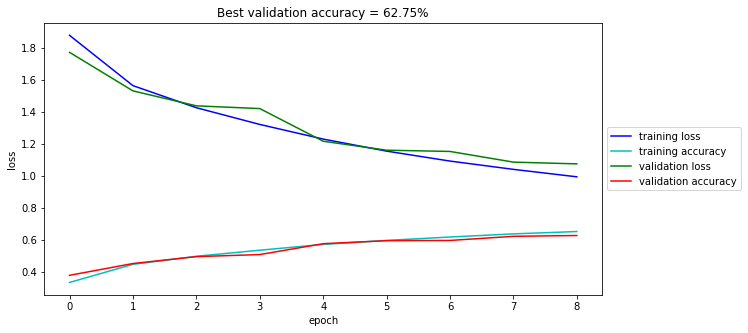

KeyboardInterrupt: 

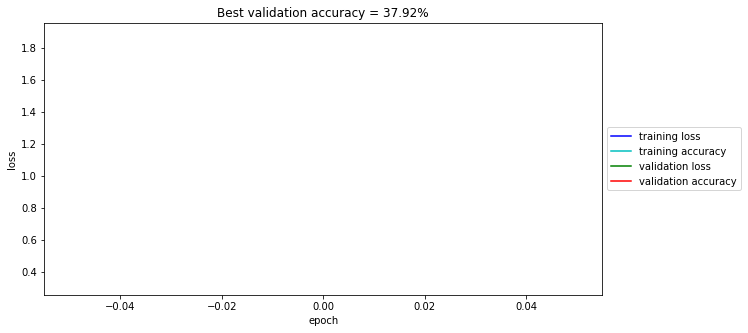

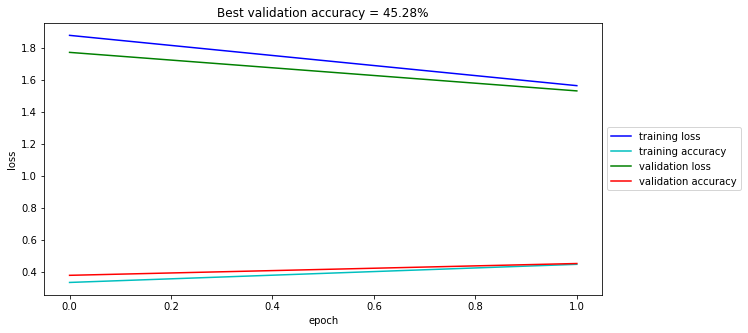

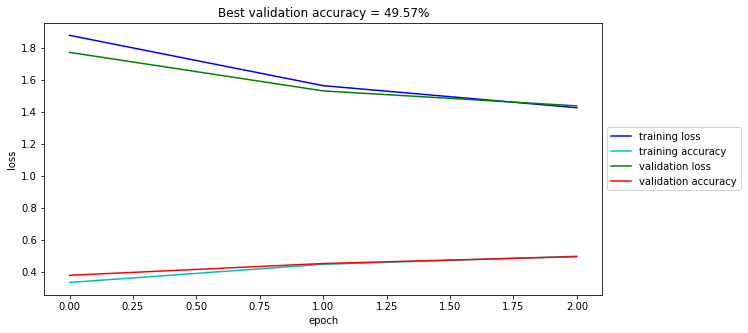

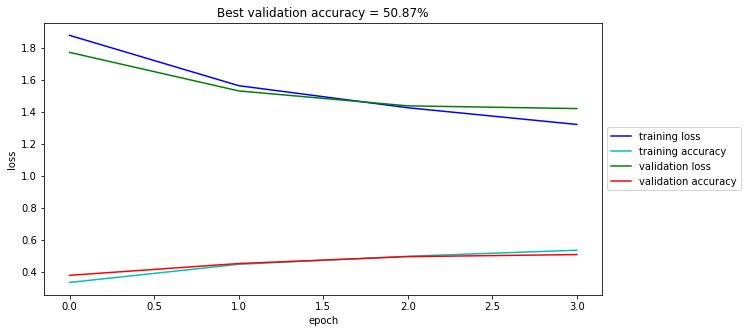

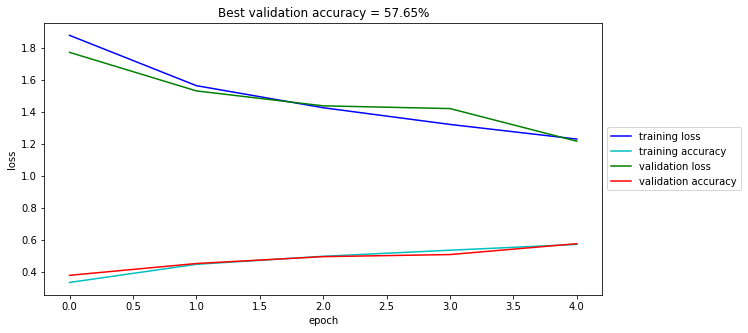

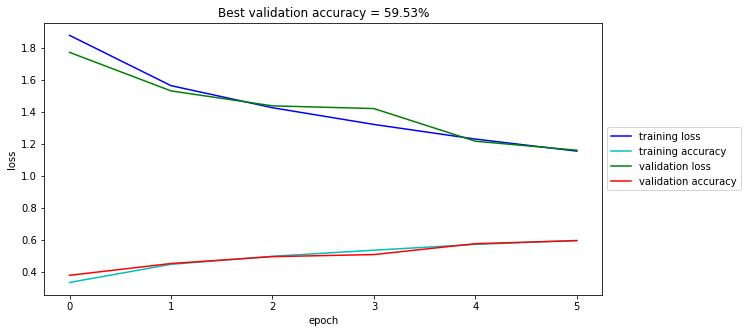

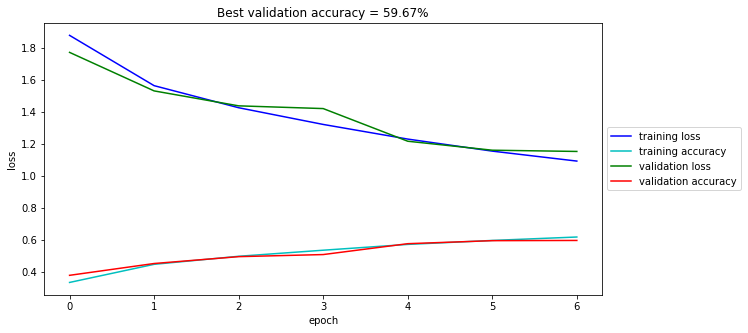

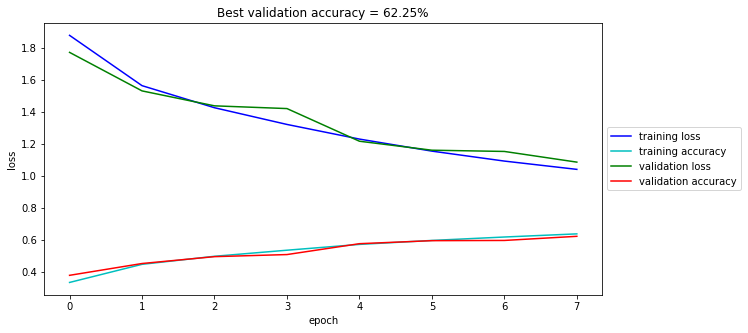

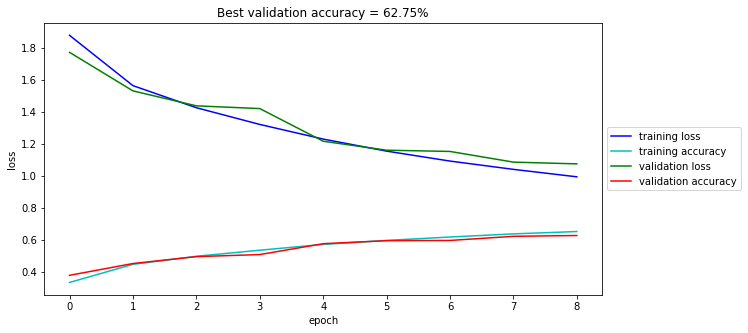

In [17]:
network_filepath = os.path.join(file_dir, network_name)

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

## Performance on test set and validation set.
Delete this before submitting!!!!

Accuracy on the test set is: 0.0996


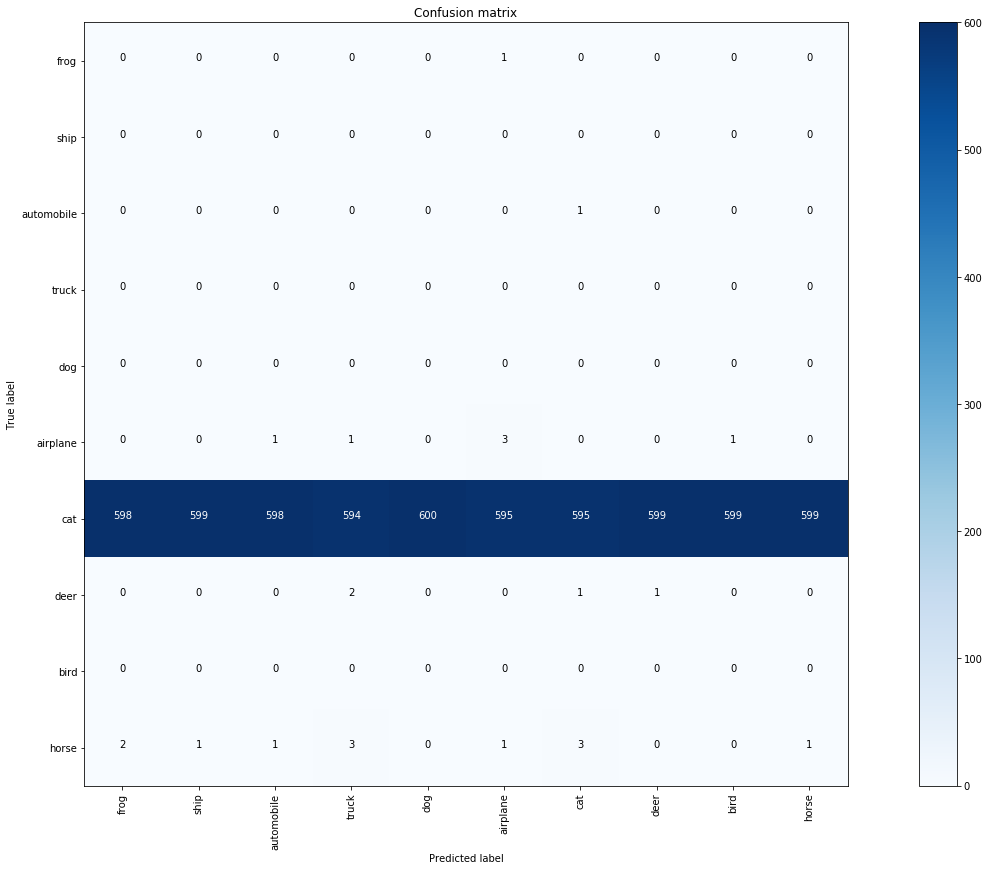

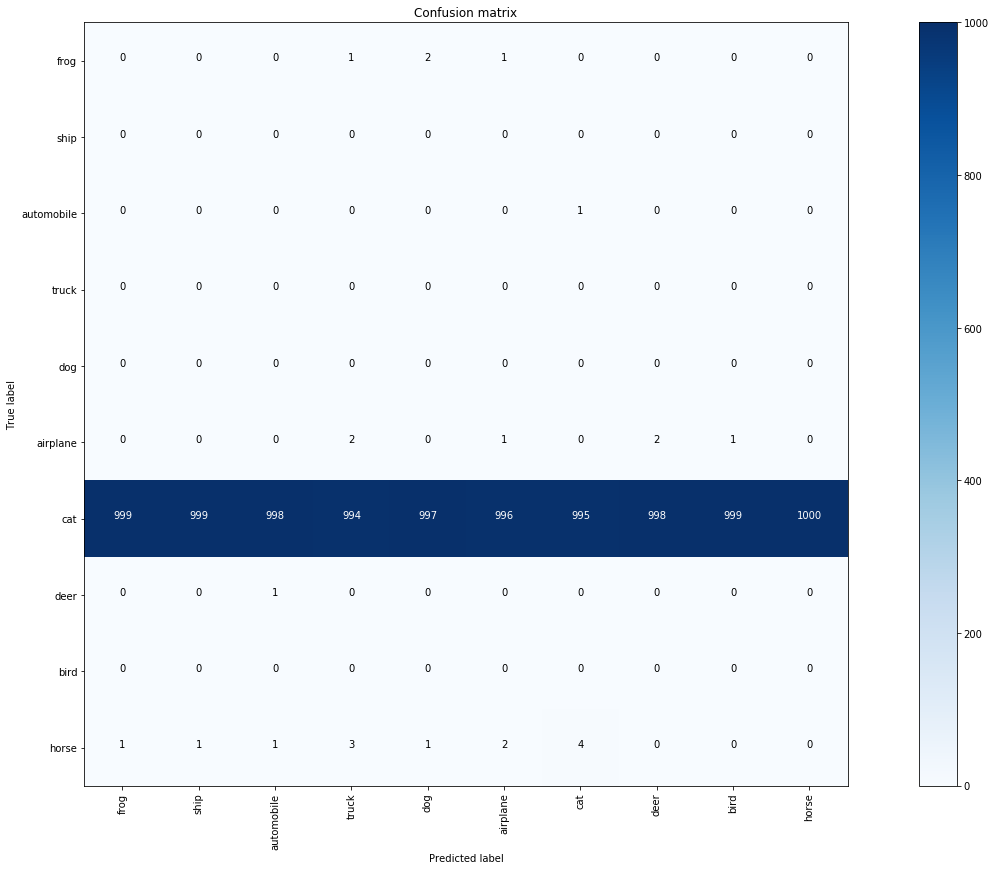

In [28]:
from sklearn.metrics import accuracy_score
import itertools
label_names = {'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

preds = np.argmax(network.predict(val_x), axis=1)
conf_mat = confusion_matrix(preds, val_y)

plot_confusion_matrix(conf_mat, label_names, title='Confusion matrix', cmap=plt.cm.Blues)


# Repeat process for test set
# TODO: DELETE TEST SET PART BEFORE SUBMISSION!!!

preds_test = np.argmax(network.predict(test_x), axis=1)
acc_test = accuracy_score(preds_test,test_y)
print("Accuracy on the test set is:", acc_test)

plt.figure()
conf_mat_test = confusion_matrix(preds_test, test_y)
plot_confusion_matrix(conf_mat_test, label_names, title='Confusion matrix', cmap=plt.cm.Blues)


### Test and submit results to grand-challenge
Now you can run the network on the test set, get the predicted labels, and submit the results to https://ismi-cifar.grand-challenge.org/introduction/ for evaluation. Use the following code (copy-paste) also for future tasks.

In [19]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_2'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 3: Add dropout layers
Modify your network and add dropout.

**Hint**: dropout is typically added to fully-connected layers, but it can be applied to convolutional layers as well.

In order to prepare and run your experiment, copy and modify previous cells to fill in the next three cells. Please do the same for the following tasks as well.

In [20]:
def build_neural_network_drop(data_size_in, n_classes):
    
    inputs = layers.Input(shape=data_size_in)
    # 32 filters, each of size 3 * 3
    x = layers.Conv2D(filters=32,kernel_size=(3,3))(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # 64 filters, each of size 2 * 2
    # TODO should we also add a dropout layer here? Considering the hint above? - Lisette
    x = layers.Conv2D(filters=64,kernel_size=(2,2))(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(3,3))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=128,activation='relu')(x)
    x = layers.Dropout(rate=0.2)(x)
    # readout layer
    readout = layers.Dense(units=n_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs,outputs=readout)
    
    print(model.summary())
    
    return model

build_neural_network_drop((32,32,3),10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               204928    
__________

In [21]:
# Compile the network, you can copy code from the first task.

### Replace None with your code ###
loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
optimizer = optimizers.Adam(lr=learning_rate) # define Adam as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_drop(data_size_in, n_classes)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               204928    
__________

In [22]:
# train and validate the network
batch_size = 128
n_epoch = 25
file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_net_dropout.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)


KeyboardInterrupt: 

## Performance on test and validation set

Delete before submitting

Accuracy on the test set is: 0.2589


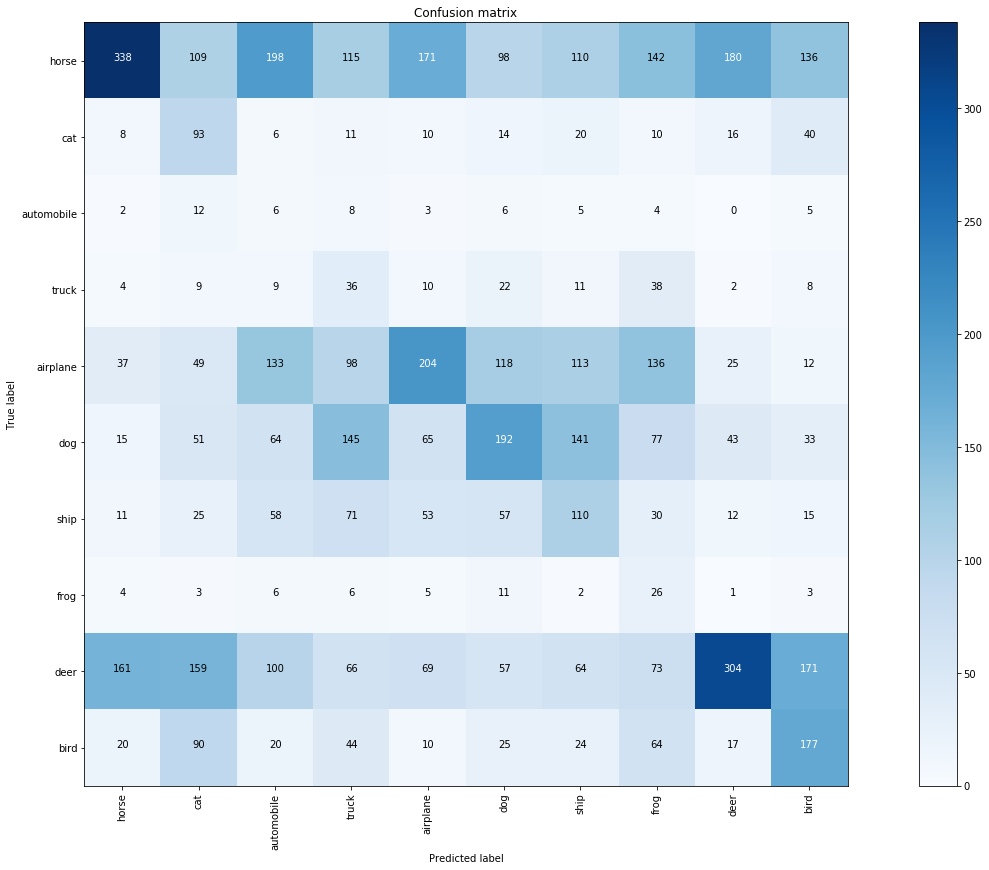

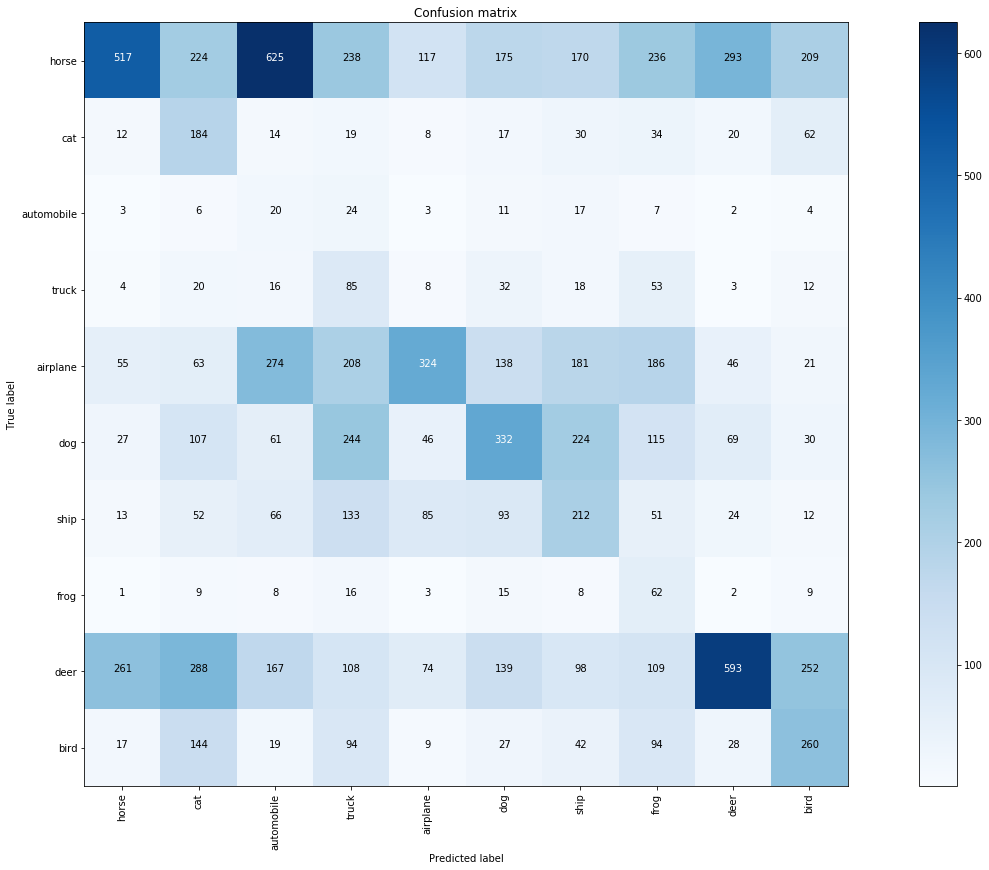

In [23]:
preds = np.argmax(network.predict(val_x), axis=1)
conf_mat = confusion_matrix(preds, val_y)

plot_confusion_matrix(conf_mat, label_names, title='Confusion matrix', cmap=plt.cm.Blues)


# Repeat process for test set
# TODO: DELETE TEST SET PART BEFORE SUBMISSION!!!

preds_test = np.argmax(network.predict(test_x), axis=1)
acc_test = accuracy_score(preds_test,test_y)
print("Accuracy on the test set is:", acc_test)

plt.figure()
conf_mat_test = confusion_matrix(preds_test, test_y)
plot_confusion_matrix(conf_mat_test, label_names, title='Confusion matrix', cmap=plt.cm.Blues)

## Question
The learning curves changed after adding dropout. How, and why?

The validation loss is closer to the training loss after adding dropout, the best model has a higher accuracy and the losses and accuracies converge slower. We can also see that without dropout the validation accuracy became constantly worse than the training accuracy, indicating overfitting. With dropout this is later/ does not occur. # TODO check after training on whole dataset#.

These improvements are because by dropping out random neurons during training, the neurons cannot rely on any one feature, as well as simulating ensemble learning, since no sample is trained on by the same network. This greatly reduces the risk of overfitting, makes the model more robust and improves generalization. 

### Test and submit results to grand-challenge
Now you can run the network on the test set, get the predicted labels, and submit the results to grand-challenge.org for evaluation. Use the following code (copy-paste) also for future tasks.

In [24]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_3'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 4: Add batch normalization
Add batch normalization to your network.

In [25]:
def build_neural_network_batch_norm(data_size_in, n_classes):
    
    inputs = layers.Input(shape=data_size_in)
    # 32 filters, each of size 3 * 3
    x = layers.Conv2D(filters=32,kernel_size=(3,3))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # 64 filters, each of size 2 * 2
    x = layers.Conv2D(filters=64,kernel_size=(2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(3,3))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=128,activation='relu')(x)
    x = layers.Dropout(rate=0.2)(x)
    # readout layer
    readout = layers.Dense(units=n_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs,outputs=readout)
    
    print(model.summary())
    
    return model

In [26]:
# Compile the network, you can copy code from the first task.

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_batch_norm(data_size_in, n_classes)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [ ]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_batchnorm.h5')

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

### Test and submit results to grand-challenge
Now you can run the network on the test set, get the predicted labels, and submit the results to grand-challenge.org for evaluation. Use the following code (copy-paste) also for future tasks.

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_4'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 5: Try different initialization strategies
Try different Weight initialization strategies in your network. Make a new cell for each different strategy and retrain your network every time. Please see https://keras.io/initializers/ for examples.

In [29]:
def build_neural_network_diff_init(data_size_in, n_classes, initializer):
    
    inputs = layers.Input(shape=data_size_in)
    # 32 filters, each of size 3 * 3
    x = layers.Conv2D(filters=32,kernel_size=(3,3),kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # 64 filters, each of size 2 * 2
    x = layers.Conv2D(filters=64,kernel_size=(2,2),kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(3,3))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=128,activation='relu',kernel_initializer=initializer)(x)
    x = layers.Dropout(rate=0.2)(x)
    # readout layer
    readout = layers.Dense(units=n_classes, activation='softmax',kernel_initializer=initializer)(x)
    
    model = models.Model(inputs=inputs,outputs=readout)
    
    print(model.summary())
    
    return model

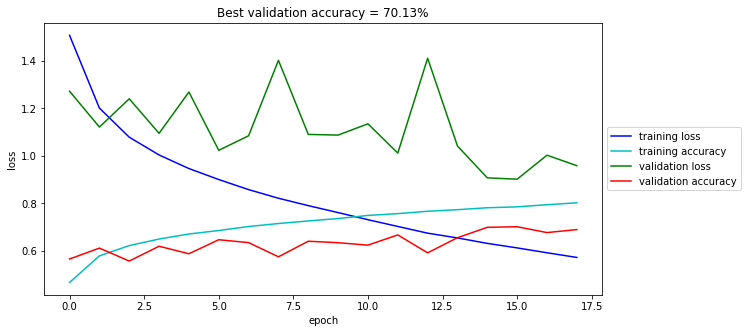

KeyboardInterrupt: 

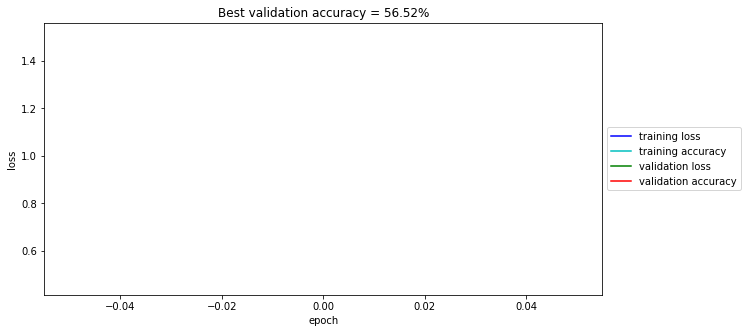

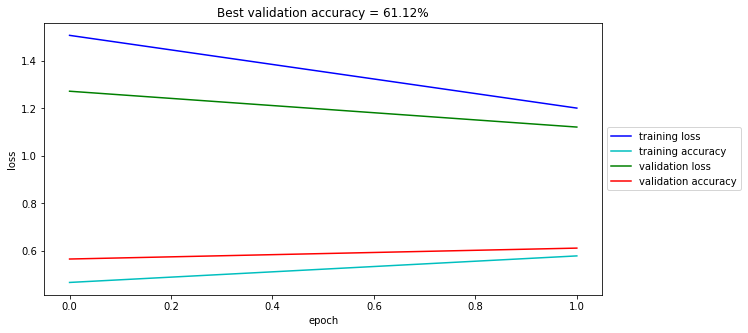

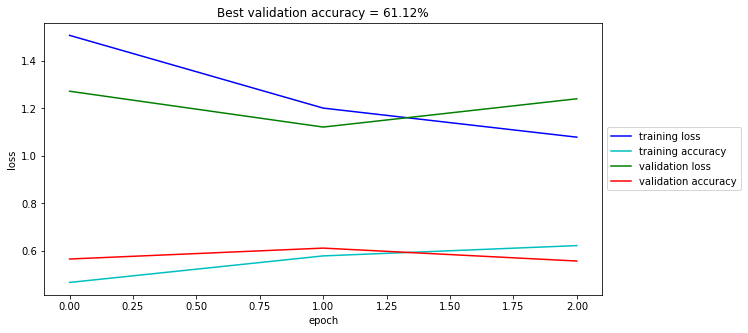

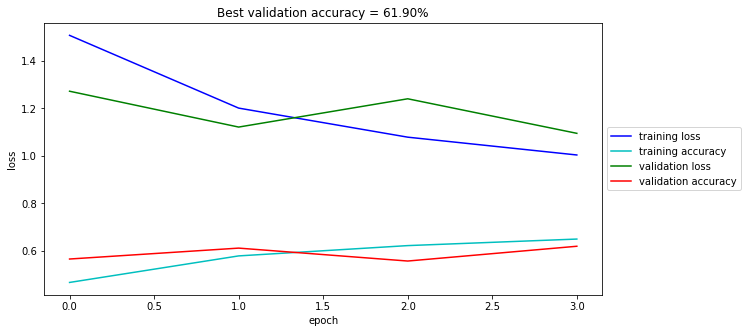

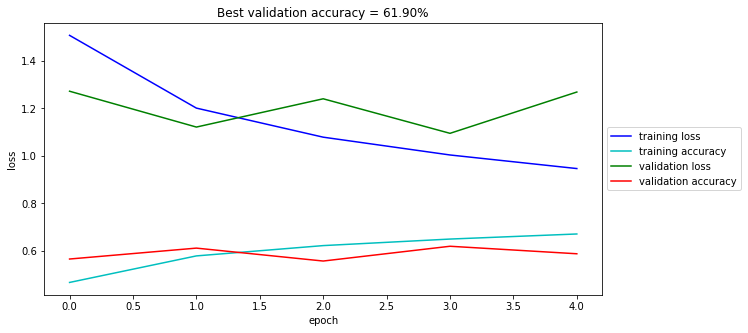

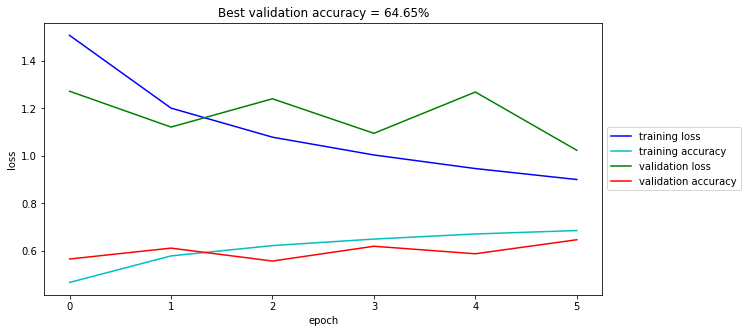

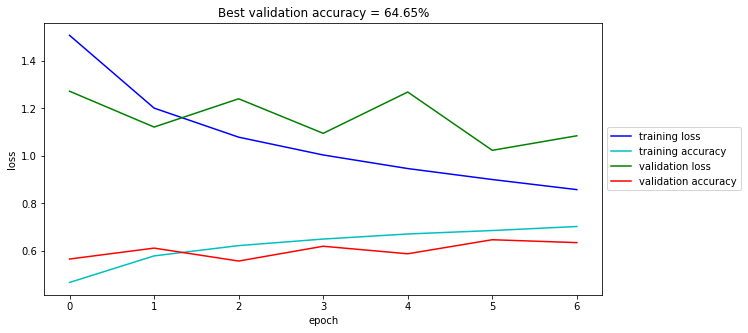

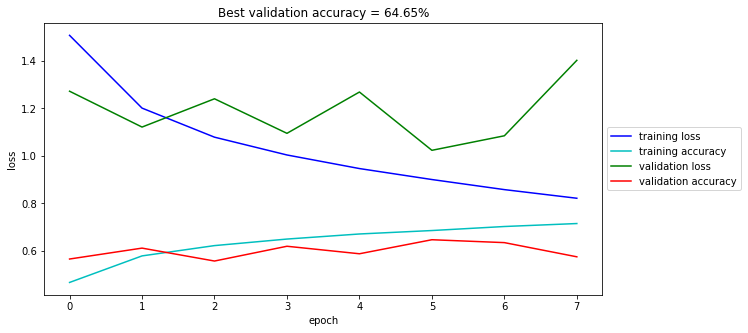

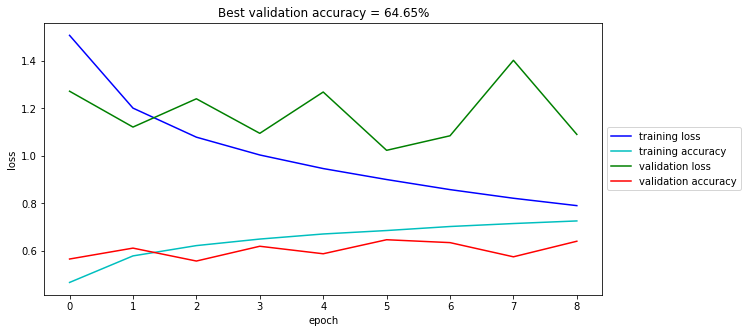

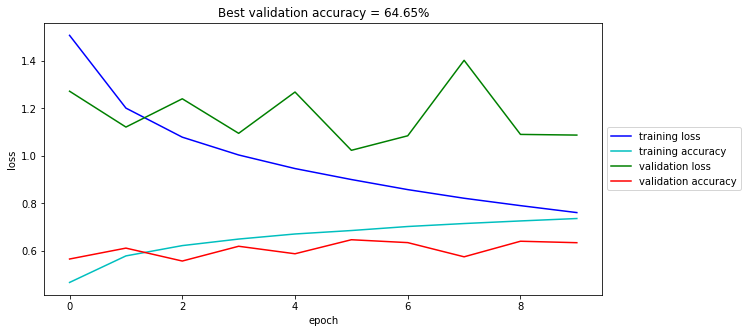

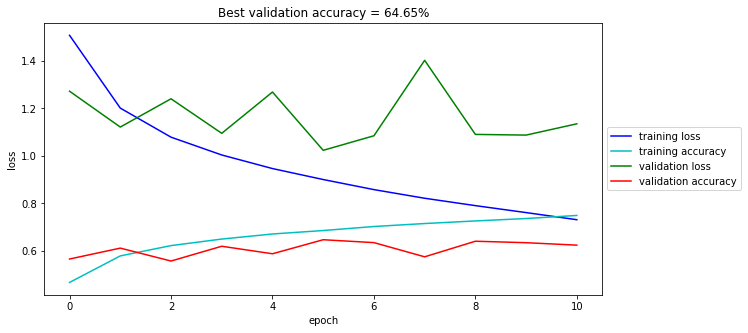

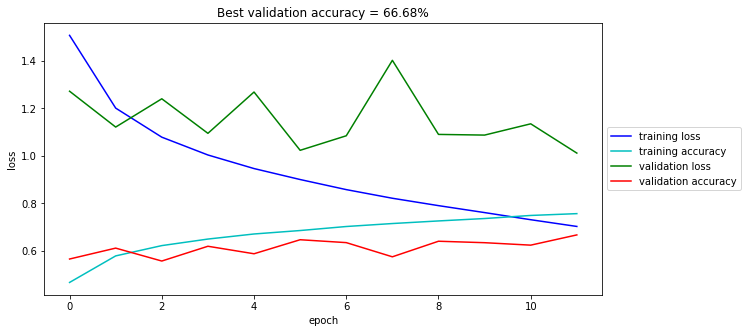

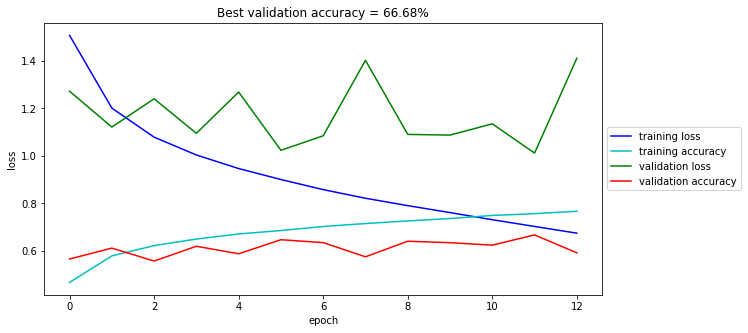

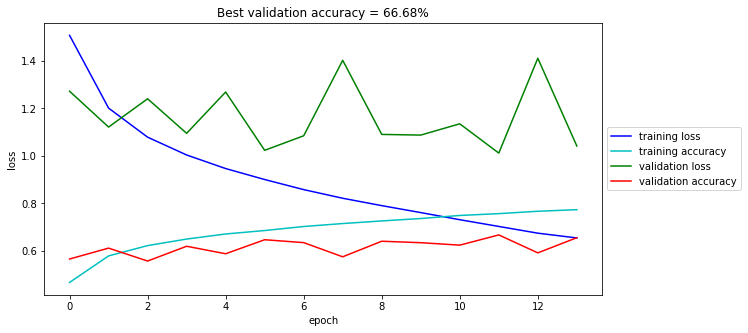

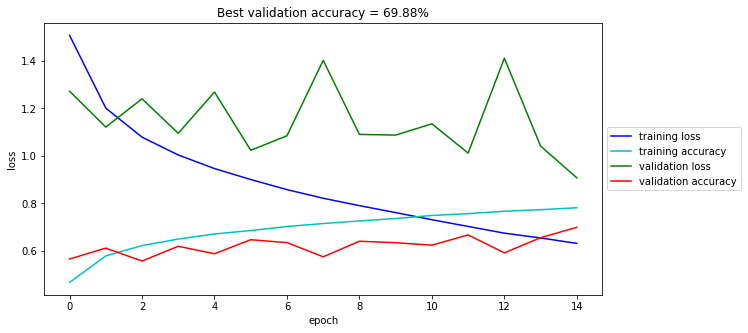

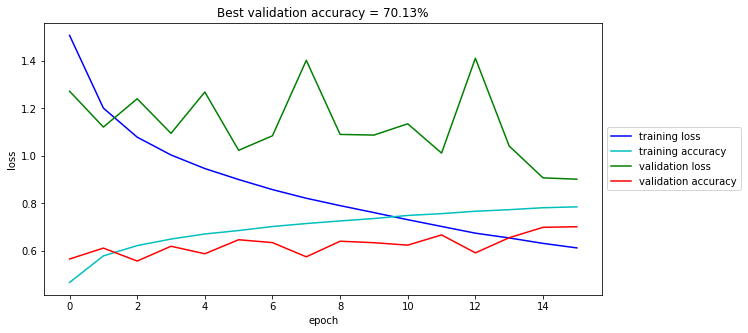

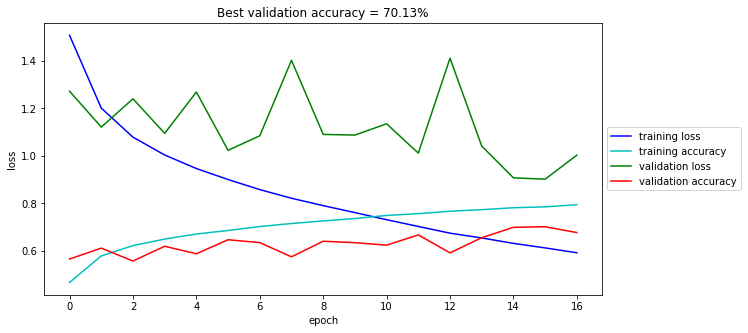

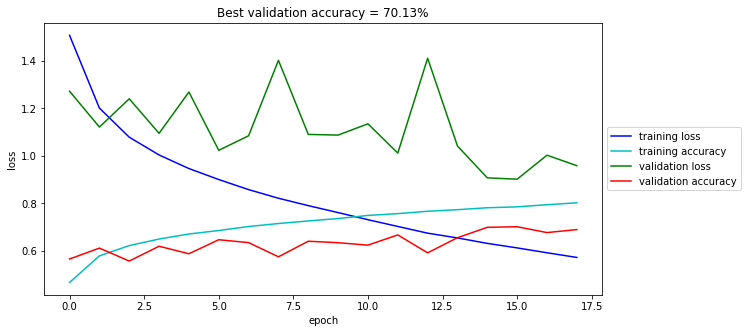

In [30]:
initializer = 'lecun_uniform'

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_diff_init(data_size_in, n_classes,initializer)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)
# train and validate the network
path = 'best_model_net_{}.h5'.format(initializer)
network_filepath = os.path.join(file_dir, path)

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)
print("===== lecun_uniform initializer =====")
plt.figure()

In [ ]:
initializer = 'glorot_uniform'

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_diff_init(data_size_in, n_classes,initializer)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)
# train and validate the network
path = 'best_model_net_{}.h5'.format(initializer)
network_filepath = os.path.join(file_dir, path)

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)
print("===== glorot_uniform initializer =====")
plt.figure()

In [ ]:
initializer = 'he_uniform'

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_diff_init(data_size_in, n_classes,initializer)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)
# train and validate the network
path = 'best_model_net_{}.h5'.format(initializer)
network_filepath = os.path.join(file_dir, path)

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)
print("===== he_uniform initializer =====")
plt.figure()

### Test and submit results to grand-challenge
Now you can run the network on the test set, get the predicted labels, and submit the results to grand-challenge.org for evaluation. Use the following code (copy-paste) also for future tasks.

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_5'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 6: Try different nonlinearities
Try different nonlinearities in your network. You can view supported activations functions in the Keras documentation: https://keras.io/activations/. If you want you can also try the advanced activations; these are implemented as layers.

In [ ]:
def build_neural_network_diff_nonlin(data_size_in, n_classes, activation):    
    inputs = layers.Input(shape=data_size_in)
    # 32 filters, each of size 3 * 3
    x = layers.Conv2D(filters=32,kernel_size=(3,3), activation=activation)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # 64 filters, each of size 2 * 2
    x = layers.Conv2D(filters=64,kernel_size=(2,2),activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(3,3))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=128,activation=activation)(x)
    x = layers.Dropout(rate=0.2)(x)
    # readout layer
    readout = layers.Dense(units=n_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs,outputs=readout)
    
    print(model.summary())
    
    return model

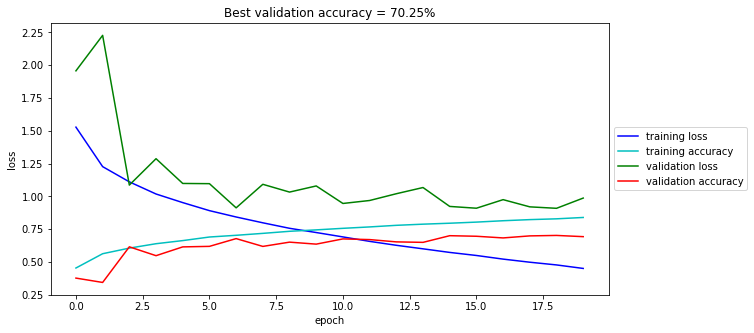

KeyboardInterrupt: 

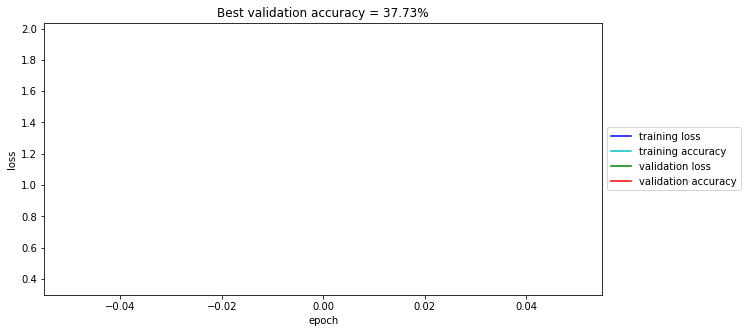

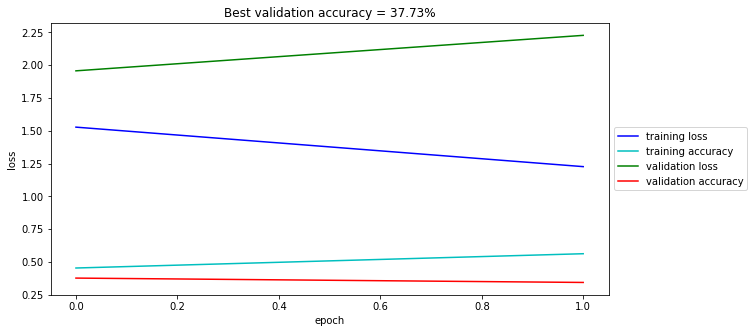

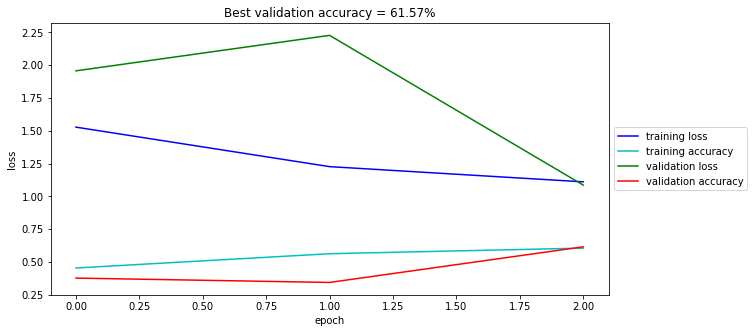

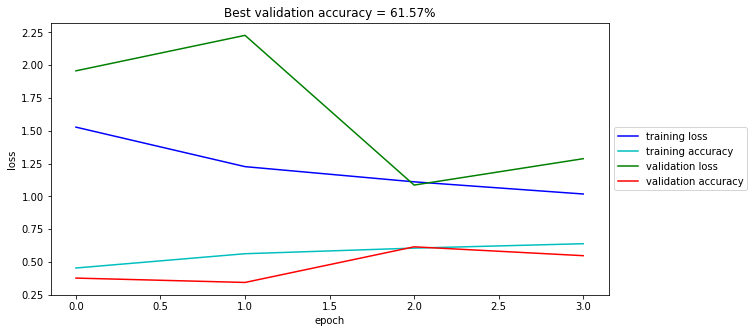

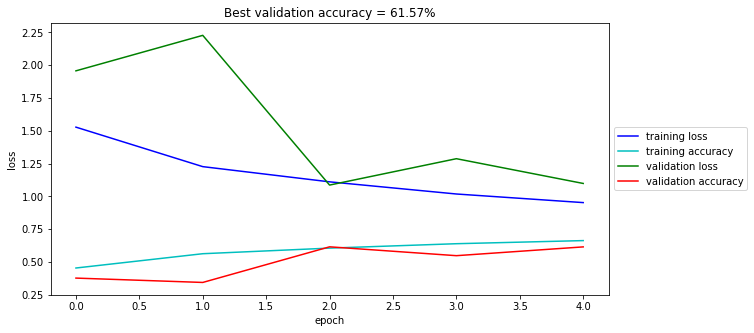

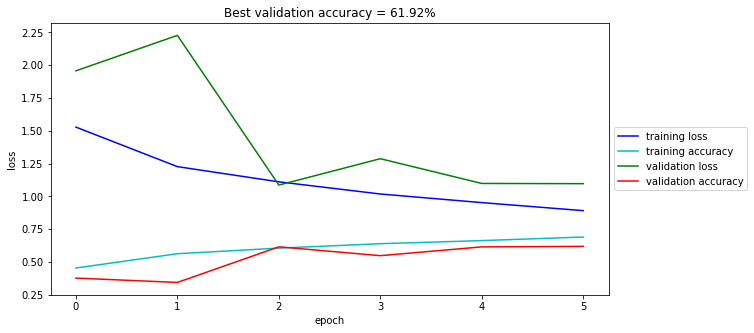

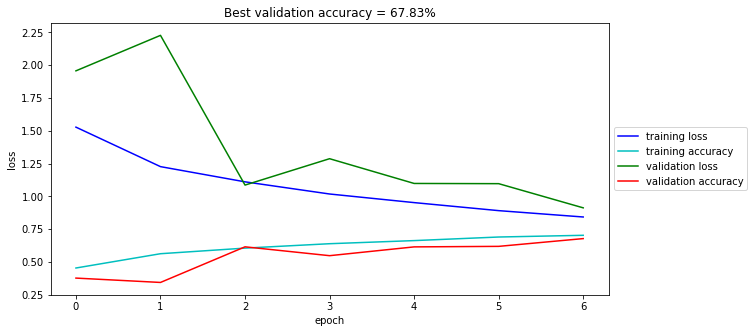

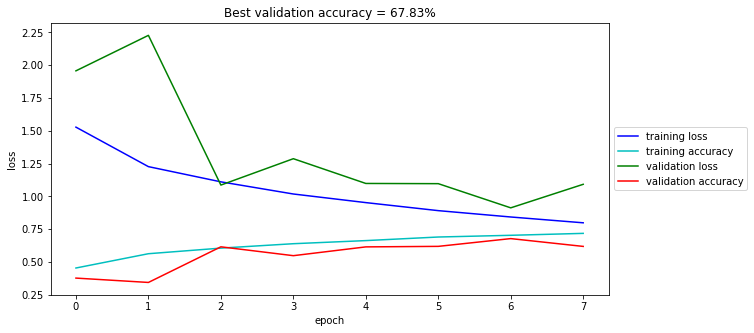

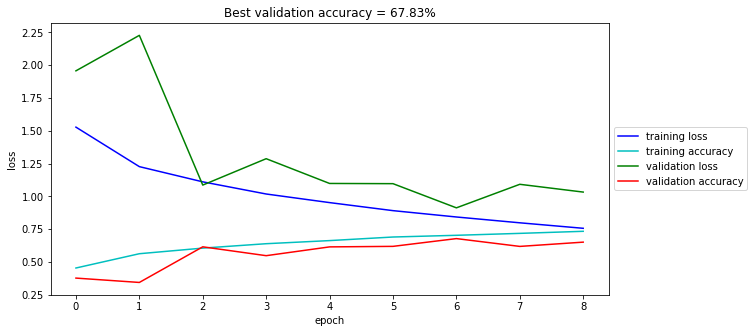

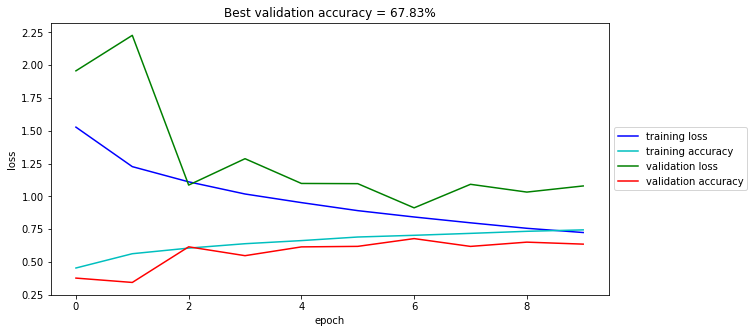

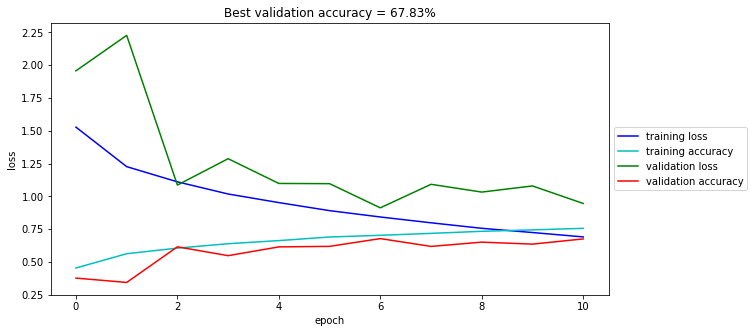

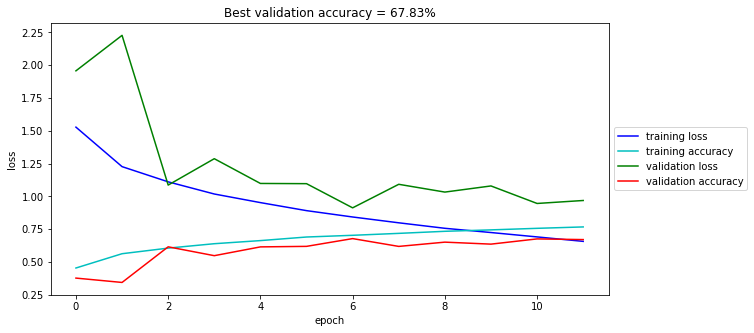

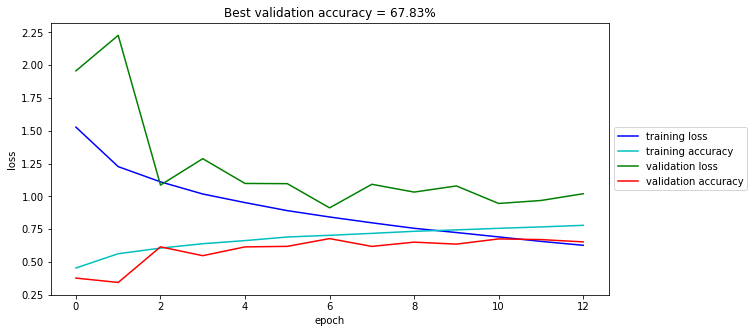

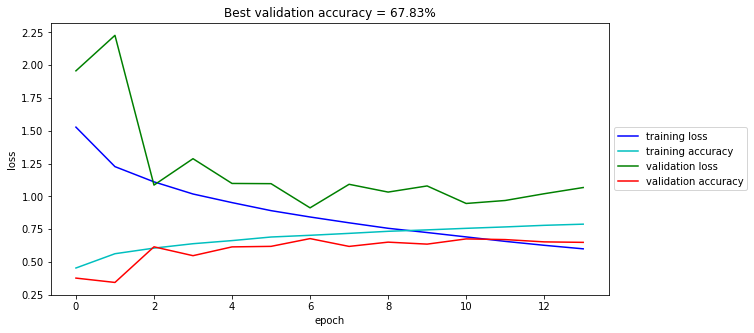

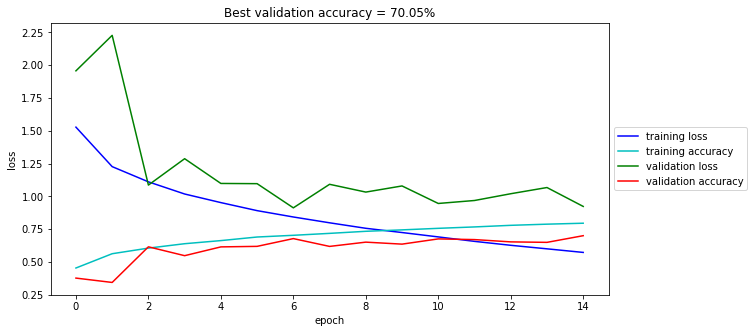

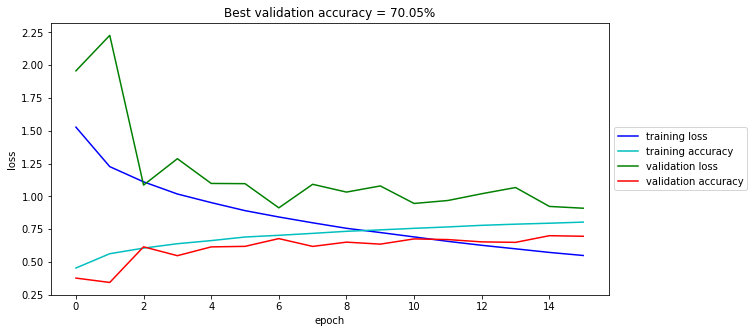

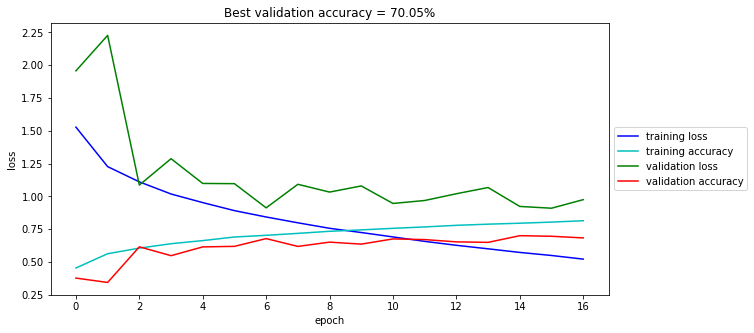

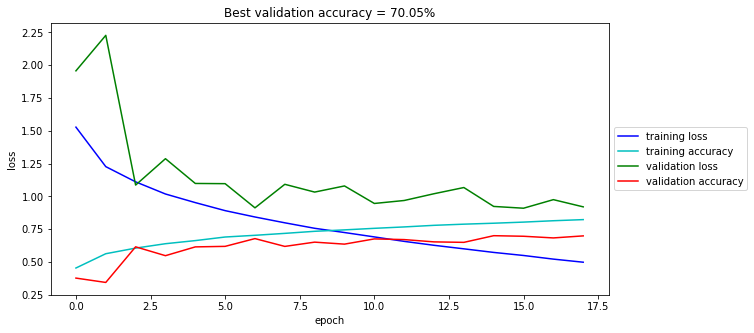

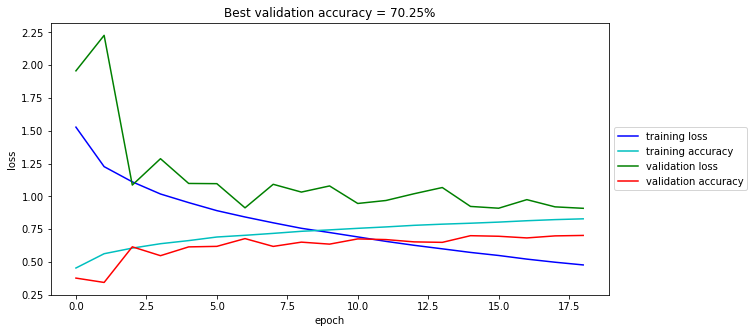

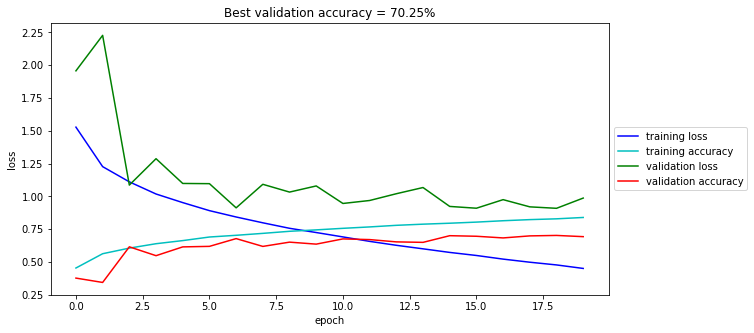

In [30]:
nonlinear = 'relu'

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_diff_nonlin(data_size_in, n_classes,nonlinear)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_nonlin_{}.h5'.format(nonlinear))
print("===== relu =====")
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
nonlinear = 'tanh'

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_diff_nonlin(data_size_in, n_classes,nonlinear)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_nonlin_{}.h5'.format(nonlinear))
print("===== tanh =====")
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
nonlinear = 'exponential'

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_diff_nonlin(data_size_in, n_classes,nonlinear)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_nonlin_{}.h5'.format(nonlinear))
print("===== exponential =====")
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
nonlinear = 'sigmoid'

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_diff_nonlin(data_size_in, n_classes,nonlinear)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_nonlin_{}.h5'.format(nonlinear))
print("===== sigmoid =====")
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

## Question
Calculating the sigmoid function is computationally expensive. What is the other main weakness of the function?

The biggest main weakness of using the sigmoid activation function for convolutional neural networks is that the sigmoid function kills the backpropagation of the gradient. Convolutional neural networks are trained using gradient descent and backpropagation (so derivatives and chain rules), they need derivatives which are not zero. Since the sigmoid activation function converges to y=0 and y=1, the derivatives at these points are approaching 0 as well, thus killing the backpropagation of the gradient.

### Test and submit results to grand-challenge
Now you can run the network on the test set, get the predicted labels, and submit the results to grand-challenge.org for evaluation. Use the following code (copy-paste) also for future tasks.

In [38]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_6'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 7: L2 normalization
Add L2 regularization to your loss calculation. You can find examples at https://keras.io/regularizers/.

In [39]:
from keras import regularizers

def build_neural_network_l2(data_size_in, n_classes):
    
    inputs = layers.Input(shape=data_size_in)
    # 32 filters, each of size 3 * 3
    x = layers.Conv2D(filters=32,kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # 64 filters, each of size 2 * 2
    x = layers.Conv2D(filters=64,kernel_size=(2,2),kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(3,3))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=128,activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(rate=0.2)(x)
    # readout layer
    readout = layers.Dense(units=n_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(x)
    
    model = models.Model(inputs=inputs,outputs=readout)
    
    print(model.summary())
    
    return model

In [40]:
loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_l2(data_size_in, n_classes)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 64)          0         
__________

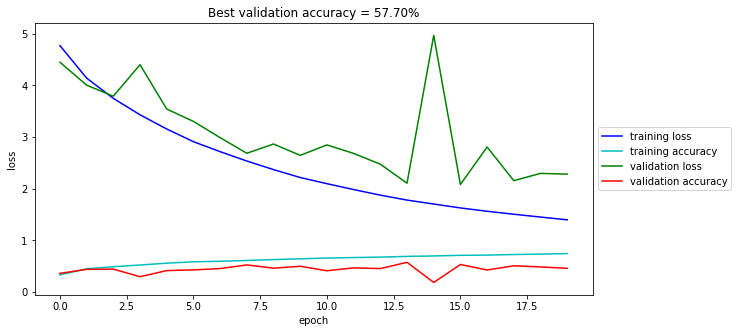

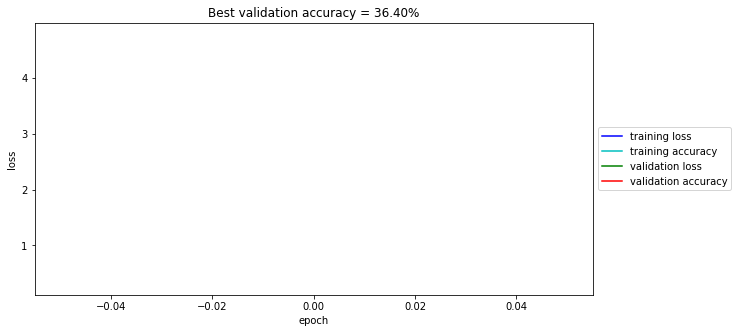

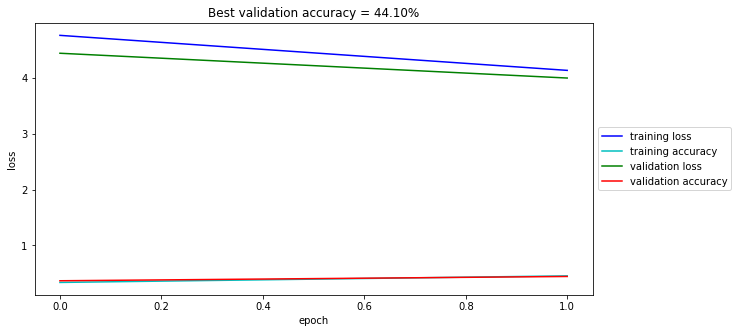

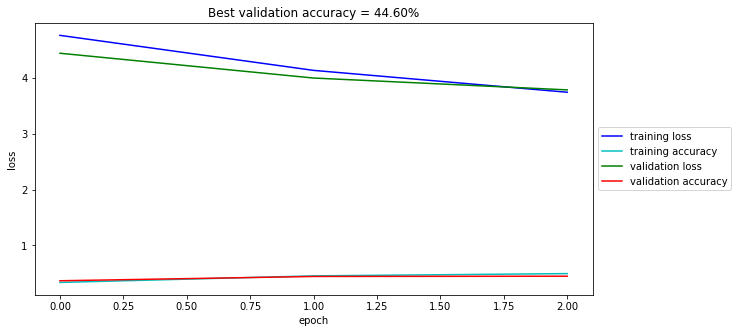

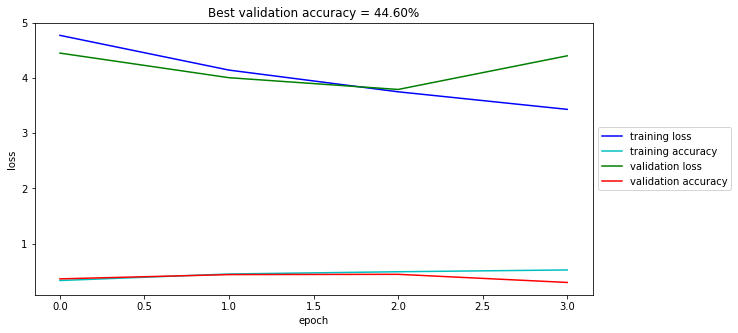

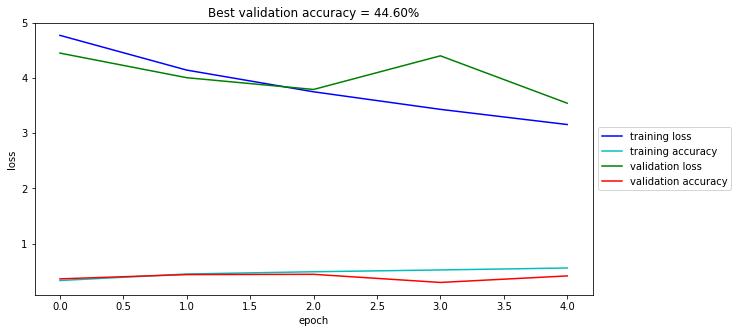

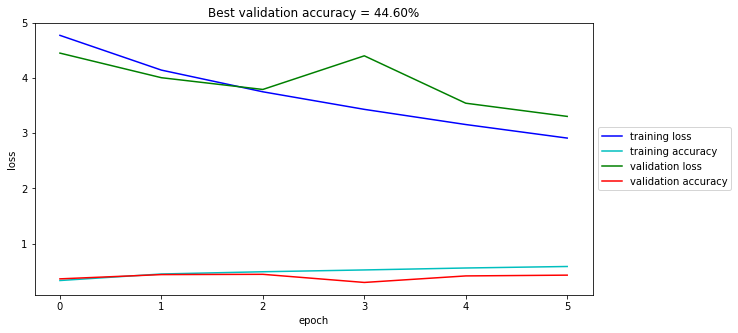

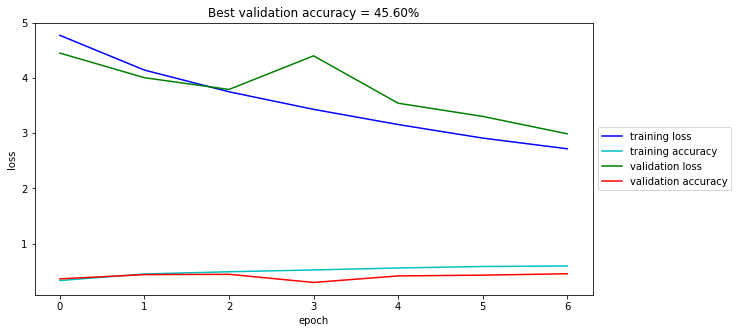

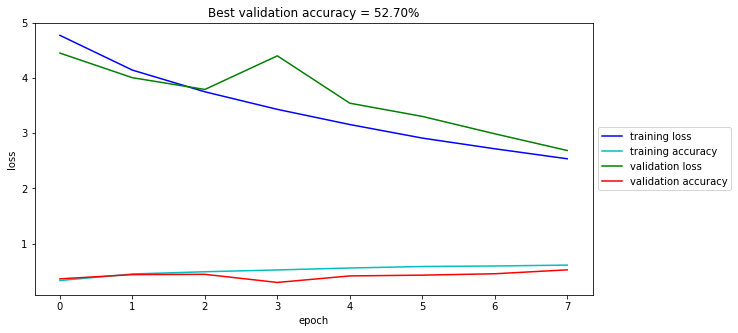

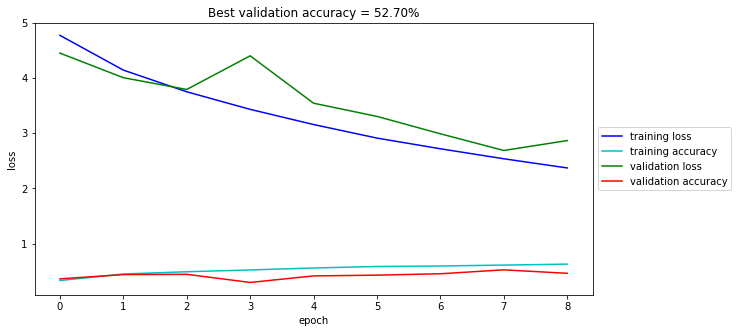

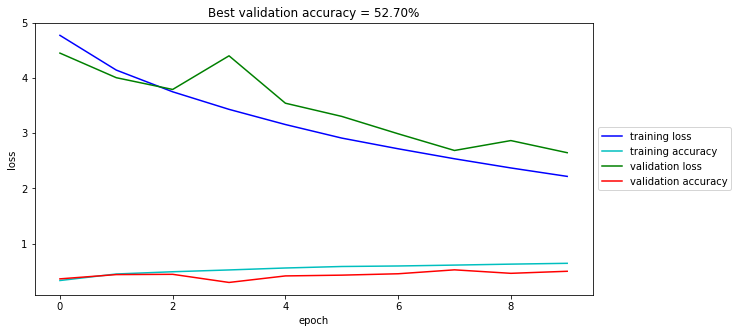

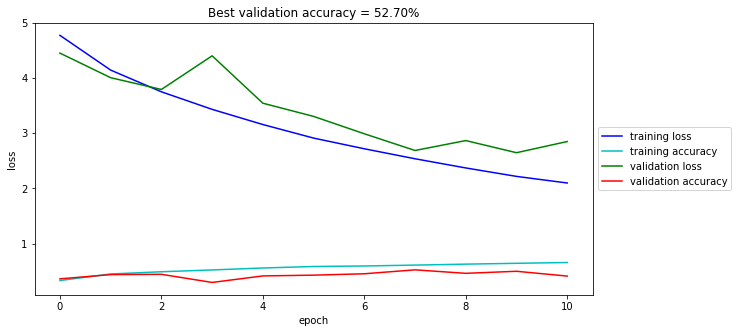

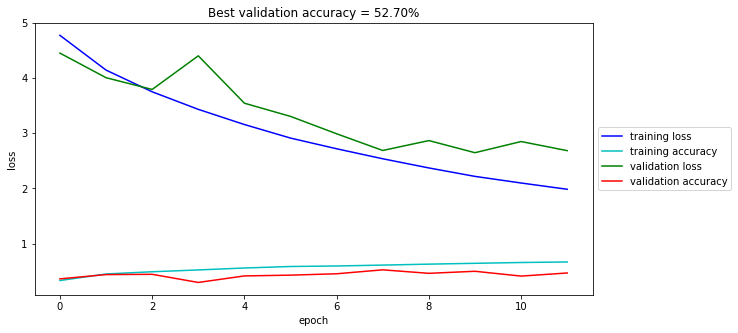

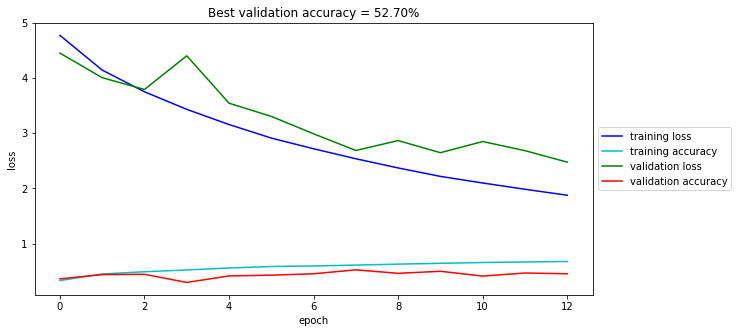

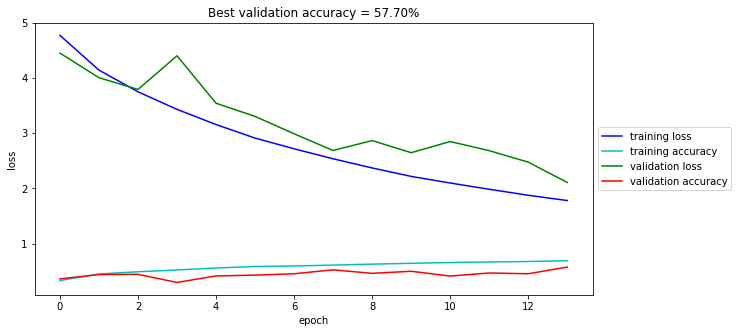

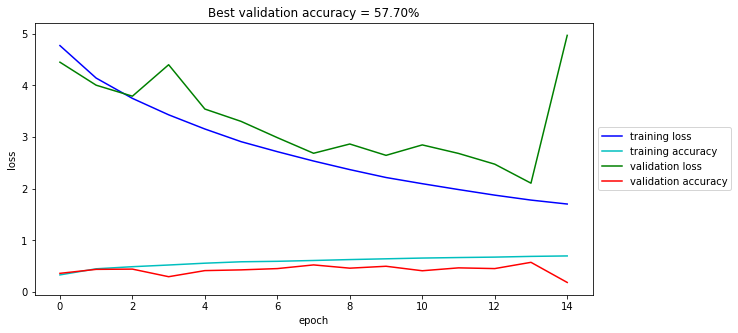

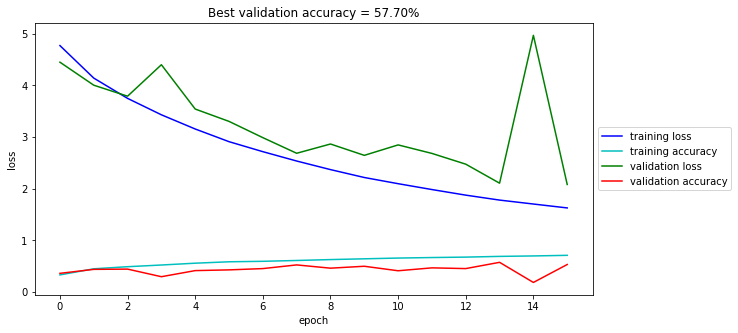

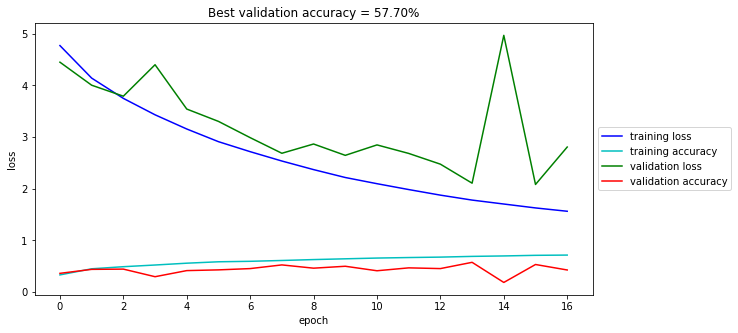

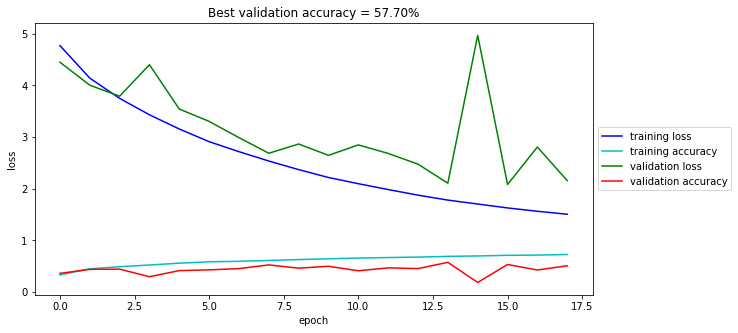

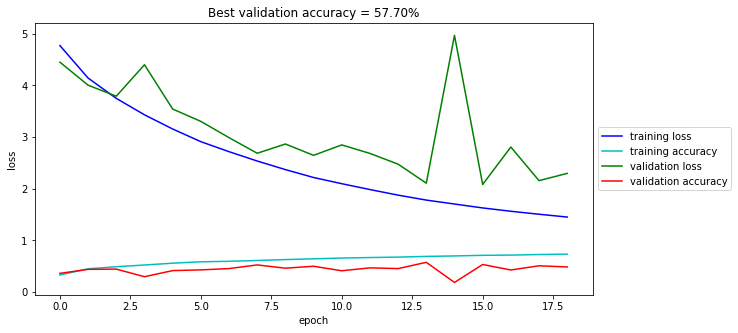

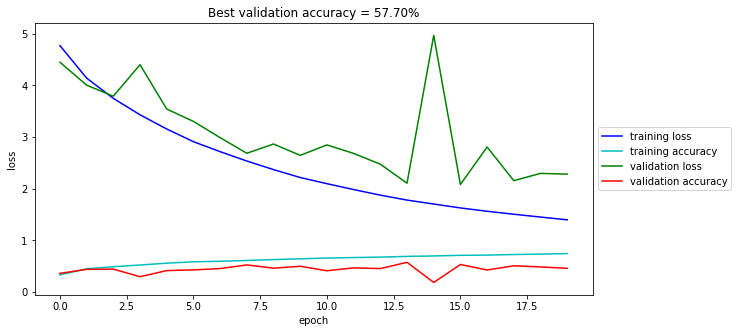

In [41]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_l2.h5')

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

## Question
Is it necessary to monitor the L2 loss during training? Why?

Too much regularization can actually cause the network to underfit. So having a combination of dropout, batch normalization, data augmentation as well as L2 regularization could be too much regularization and it is therefore important to monitor the L2 loss during training to get insights in whether it actually improves accuracy or not.
Additionally, since L2 regularization required a hyper-parameter to be defined by the user, it is generally a good idea to monitor the performance of the L2 to compare different hyperparameter values.

### Test and submit results to grand-challenge
Now you can run the network on the test set, get the predicted labels, and submit the results to grand-challenge.org for evaluation. Use the following code (copy-paste) also for future tasks.

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_7'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 8: Add data augmentation

In this task you will have to implement different data augmentation techniques. We have created a simple framework to help you with this. You will have to implement at least three functions that augment an image using some method. Think about the task and images, and decide which augmentations could help the network to generalize.

You are free to use data augmentation libraries/frameworks (for example https://pillow.readthedocs.io or https://github.com/mdbloice/Augmentor). Feel free to change the augmentation framework below if you have any other ideas to augment the data or want to use an additional framework. Make sure to document which external software packages you use (if any). If you implement the augmentations yourself **you can get up to 10 bonus points** for this assignment.

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


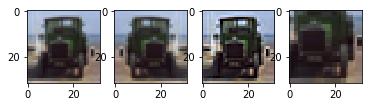

In [10]:
!pip install pillow --user
import PIL.Image
from PIL.ImageOps import mirror, crop
from PIL import ImageFilter
from random import randint
# Create (at least) three functions that take an image as input and return an augmented image
# Please give them sensible names, describing the augmentation.
def mirror_augmentation(image):
    # load into PIL format
    # Mirror the image
    i = Image.fromarray((image*255).astype('uint8'))
    i = mirror(i)
    # back into numpy array
    image = np.asarray(i)
    return image

def sharpen_augmentation(image):
    # load into PIL format
    # Sharpen image
    i = Image.fromarray((image*255).astype('uint8'))
    i = i.filter(ImageFilter.SHARPEN)
    # back into numpy array
    image = np.asarray(i)
    return image

def crop_augmentation(image):
    # load into PIL format
    i = Image.fromarray((image*255).astype('uint8'))
    # random cropping: randomly crop some part of the image
    # Start by resizing the image to a larger format so we do not get shape issues later on
    # Resize can be any size > 32 * 32
    i = i.resize((45, 45 ))
    # a random square of the image gets cropped:
    rx = randint(0, 13)
    ry = randint(0, 13)
    image = i.crop((rx, ry, rx + 32, ry + 32))
    return image

# Fill this array with your augmentation functions
augmentations = [mirror_augmentation, sharpen_augmentation, crop_augmentation]

# Preview your augmentations on an image
test_image = train_x[1].copy()
fig, axarr = plt.subplots(ncols=len(augmentations) + 1, nrows=1)
axarr[0].imshow((test_image))
for key, augment_func in enumerate(augmentations):
    axarr[key + 1].imshow(augment_func(test_image))
plt.show()

The function below takes the original data as input and returns an augmented dataset.

In [11]:
# Function to augment data
# The ratio defines how many of the images will be augmented.

# TODO: how is this even augmentation??? we do not add images to the training set, we just change the existing ones...
def augment_data(original_data, ratio=0.2):

    data = original_data.copy()
    
    # Apply augmentations on a random portion of the data
    for augment_func in augmentations:
        indices = np.random.choice(len(data), int(len(data) * ratio))
    
        for i in indices:
            data[i] = augment_func(data[i])
    
    return data




Our train function needs to be adapted to work with the augmentations. Think about how you can do this. When do you need to apply the augmentations?

In [12]:
def train_network_with_augmentations(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit(augment_data(x_training),y_training, verbose=0)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x_validation, y_validation)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

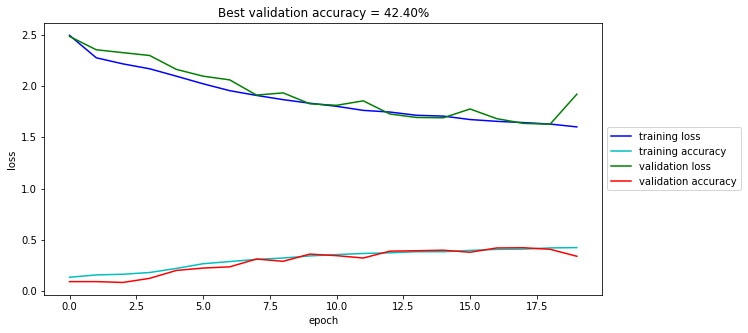

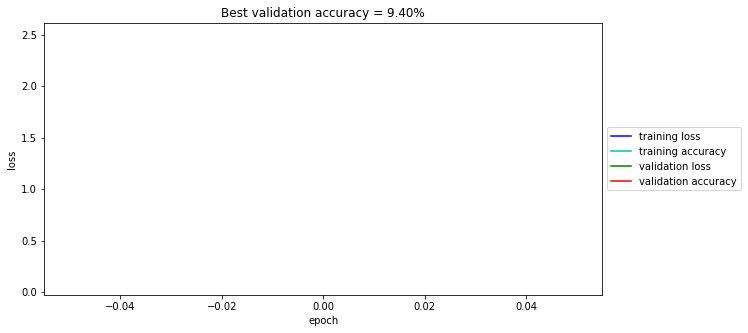

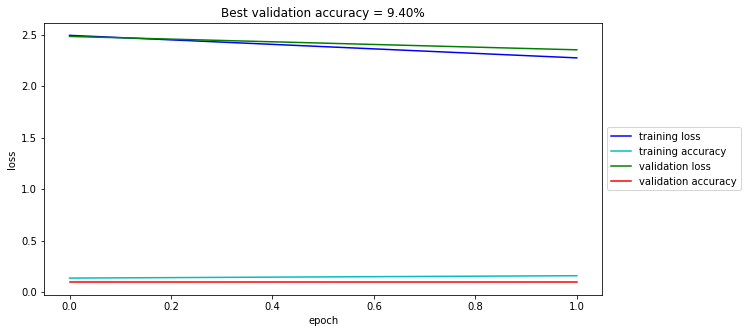

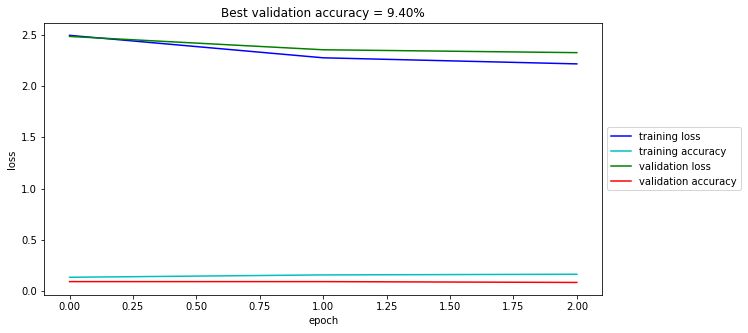

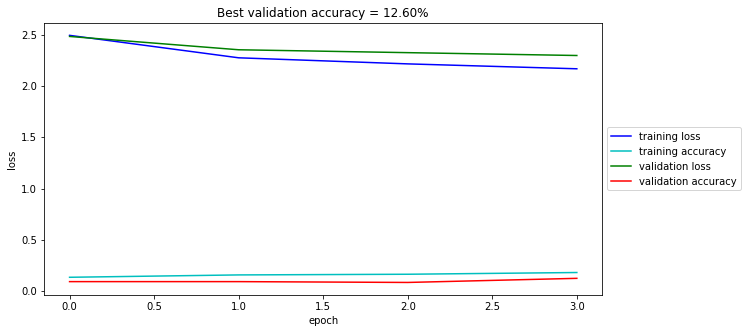

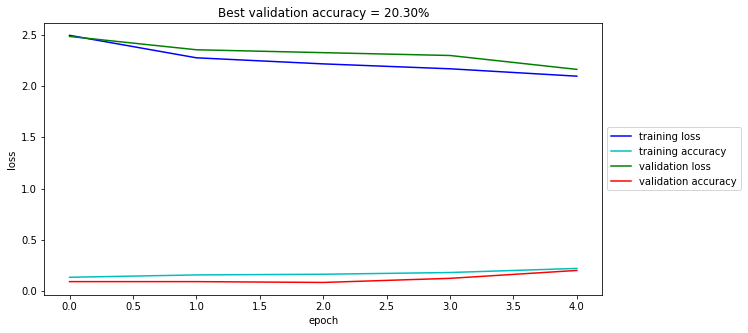

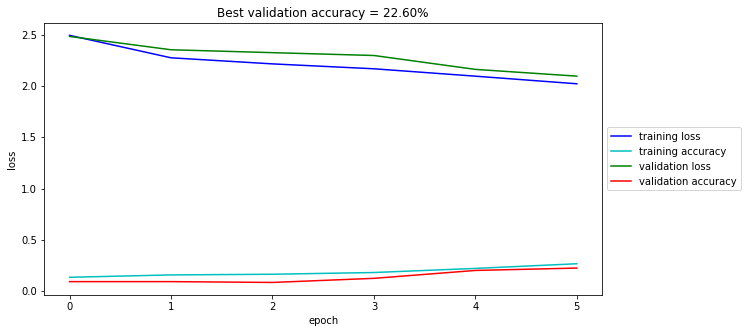

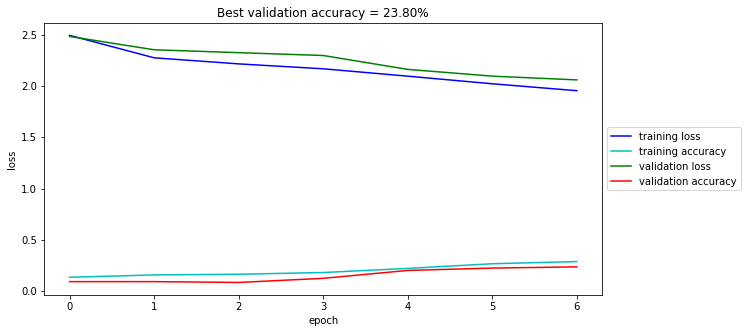

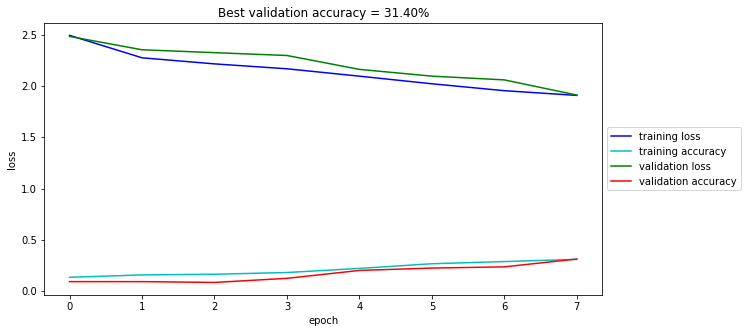

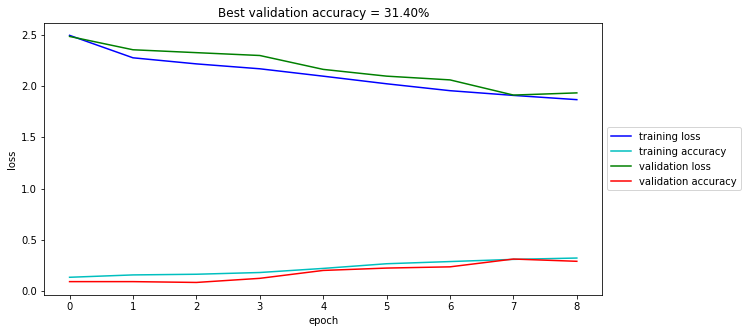

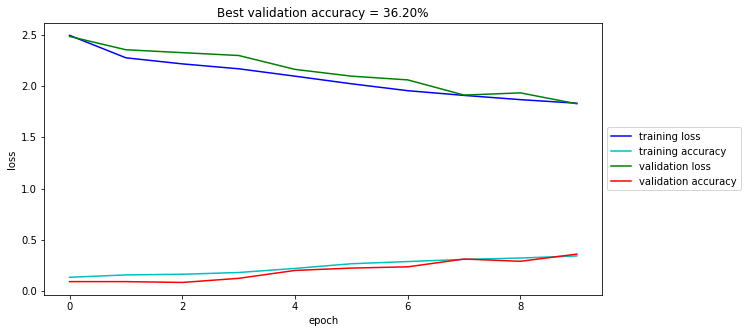

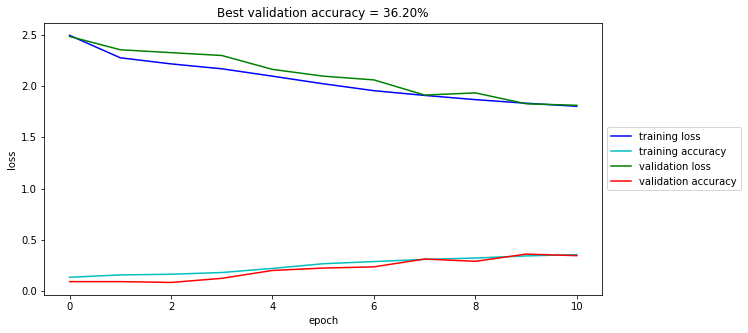

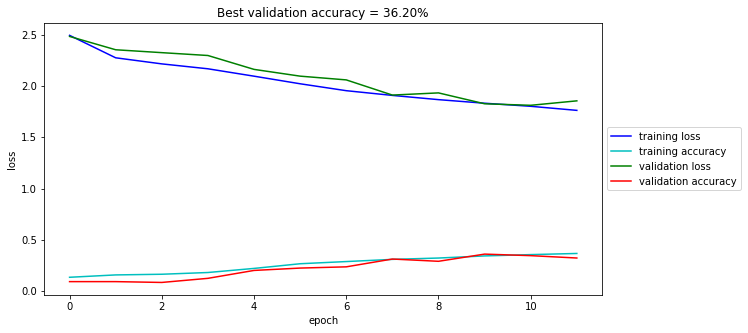

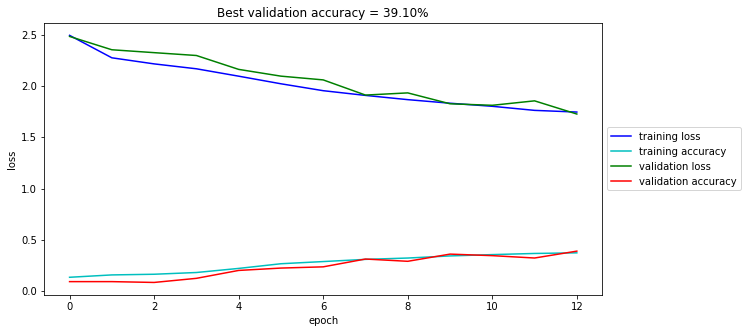

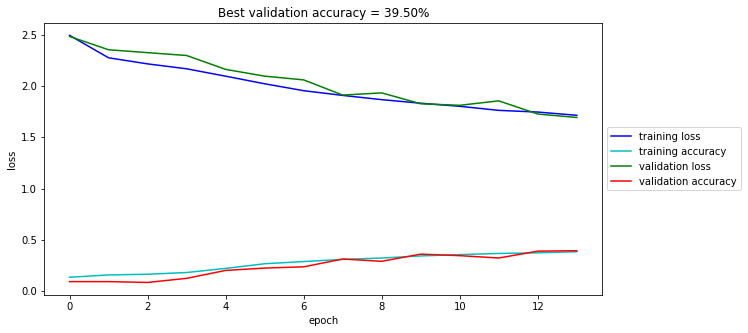

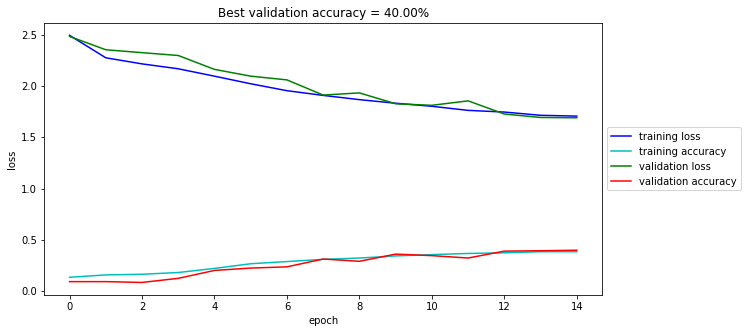

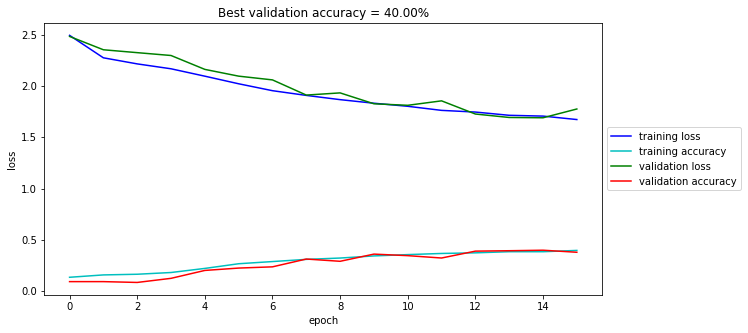

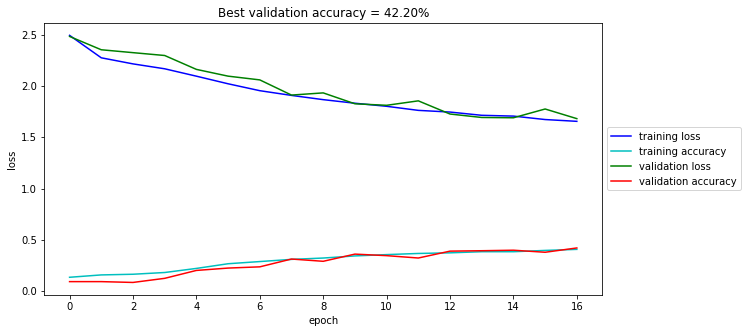

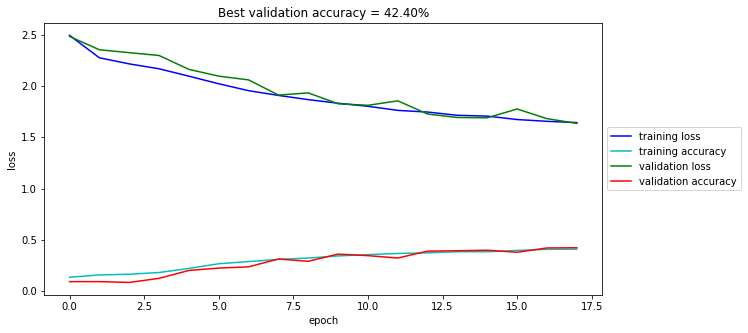

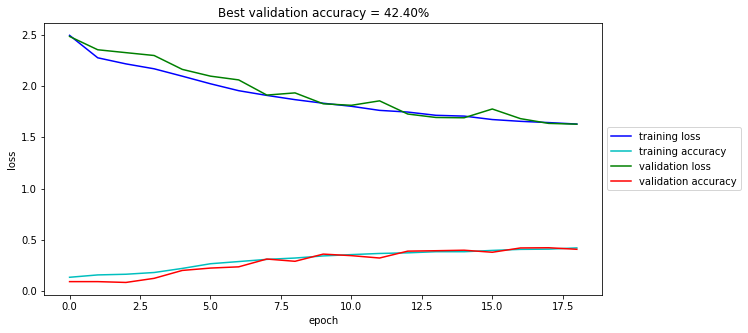

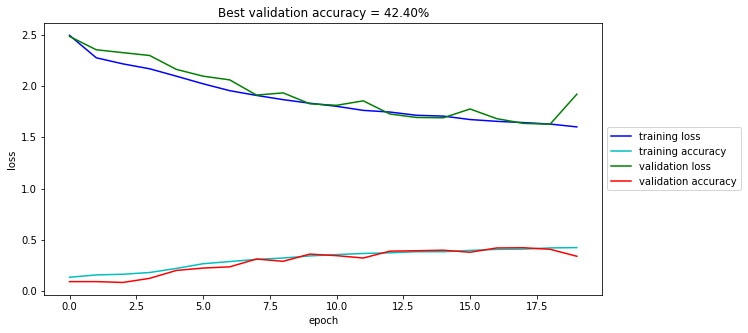

In [102]:
loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics

network = build_neural_network_diff_nonlin(data_size_in, n_classes,'relu')
network.compile(loss=loss,optimizer=sgd,metrics=metrics)


network_filepath = os.path.join(file_dir, 'best_model_net_augmentations.h5')

train_network_with_augmentations(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)


### Test and submit results to grand-challenge
Now you can run the network on the test set, get the predicted labels, and submit the results to grand-challenge.org for evaluation. Use the following code (copy-paste) also for future tasks.

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

# TODO: LITERALLY COPIED AND PASTED THIS, MAYBE DIFFERENT NETWORK?

network_name = 'network_task_8'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

#### Question
Should the upside-down flipping be used as augmentation? Why?

The upside-down flipping should not be used as augmentation, only left-to-right flipping. The images after augmentation should still be representative of the objects in the image. However, by flipping the image upside-down, the ground and the sky will also be flipped upside-down and the object itself would be upside-down. It would be a waste to train the network on unrepresentative images of the objects, because the network would train on features of the upside-down training data which would be useless or maybe even harmful when testing on the test data which are just the normal side up.

# Task 9: Try different architectures

The architectures we used so far were pretty simple. Try to build a different (deeper) architecture and see how it performs.

In [43]:
def denseblock(x_input, l, num_filters):
    x = x_input
    for _ in range(l):
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters=num_filters,kernel_size=(3,3),padding='same',use_bias=False,activation='relu')(x)
        x = layers.Concatenate(axis=-1)([x_input, x])
    return x

In [44]:
def transition(x):
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=num_filters,kernel_size=(1,1),padding='same',use_bias=False,activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(2,2))(x)
    return x

In [49]:
# Implemented a DenseNet (https://arxiv.org/abs/1608.06993) architecture with the help of https://github.com/jkh911208/cswithjames/blob/master/11_CIFAR10_DenseNet.ipynb

def build_dense_network(data_size_in, n_classes, num_filters, l):
    
    inputs = layers.Input(shape=data_size_in)
    x = layers.Conv2D(filters=num_filters,kernel_size=(3,3),padding='same',use_bias=False)(inputs)

    # Dense layers
    x = denseblock(x, l, num_filters)
    x = transition(x)
    x = denseblock(x, l, num_filters)
    x = transition(x)
    x = denseblock(x, l, num_filters)
    x = transition(x)
    
    x = denseblock(x, l, num_filters)
    x = layers.BatchNormalization()(x)
    x = layers.AveragePooling2D(pool_size=(2,2))(x)
    x = layers.Flatten()(x)
    # Readout layer
    readout = layers.Dense(n_classes, activation='softmax')(x)
        
    model = models.Model(inputs=inputs,outputs=readout)
    
    print(model.summary())
    
    return model

In [50]:
# Compile the network, you can copy code from the first task.

loss = 'categorical_crossentropy' # define the (string) loss function
learning_rate = 0.01 # pick a value for your learning rate
sgd = optimizers.SGD(lr=learning_rate) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metrics = ['accuracy'] # define (Python) list of metrics
num_filters = 20
l = 10

network = build_dense_network(data_size_in, n_classes, num_filters, l)
network.compile(loss=loss,optimizer=sgd,metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 32, 32, 20)   540         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 32, 32, 20)   80          conv2d_109[0][0]                 
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 32, 32, 20)   3600        batch_normalization_105[0][0]    
__________________________________________________________________________________________________
concatenat

In [ ]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_dense_net.h5')

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

## Performance on test and validation set

Delete before submitting

In [ ]:
preds = np.argmax(network.predict(val_x), axis=1)
conf_mat = confusion_matrix(preds, val_y)

plot_confusion_matrix(conf_mat, label_names, title='Confusion matrix', cmap=plt.cm.Blues)


# Repeat process for test set
# TODO: DELETE TEST SET PART BEFORE SUBMISSION!!!

preds_test = np.argmax(network.predict(test_x), axis=1)
acc_test = accuracy_score(preds_test,test_y)
print("Accuracy on the test set is:", acc_test)

plt.figure()
conf_mat_test = confusion_matrix(preds_test, test_y)
plot_confusion_matrix(conf_mat_test, label_names, title='Confusion matrix', cmap=plt.cm.Blues)

### Test and submit results to grand-challenge
Now you can run the network on the test set, get the predicted labels, and submit the results to grand-challenge.org for evaluation. Use the following code (copy-paste) also for future tasks.

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_9'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 10 (optional): Tools to monitor training procedure

In [ ]:
# >>> add your code here <<<

# filters should be meaningful: not too many zeroes
# Activations should not have too many zeroes
